Lesson 9 - Applied Regression Modeling - Model Selection and Prediction Part 1 (AIC, BIC)


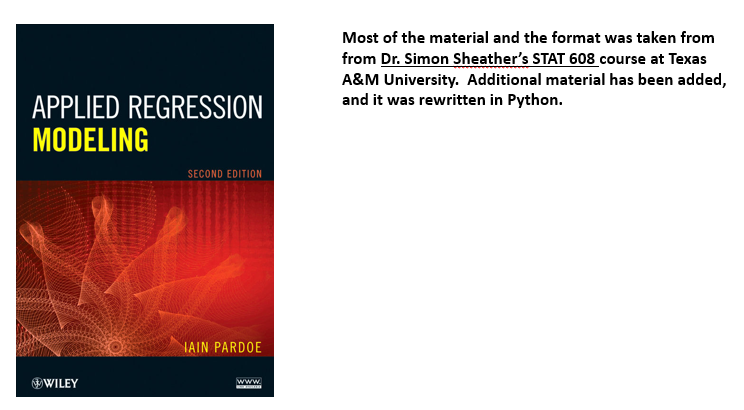

In [1]:
import mcstats_v001 as mc
import pandas as  pd
import numpy as np

In [2]:
df = pd.DataFrame({'a':[1,2],'b':[2,3]})
mc.num_columns(df)



2

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import os 
import warnings
import statsmodels.api as sm   

import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import HTML

from pandas_datareader import data
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')


pd.options.display.max_rows = 100        #Increases the number of rows displayed without a break in the middle.
pd.options.display.max_columns = 100     #Increases the number of columns displayed without a break in the middle.
pd.set_option('max_colwidth',100)        #Increases the width of the columns to display 100 characters at the same time.

# definitions

In [4]:
def num_columns(series):
    """
    returns the number of columns in a series or dataframe
    """
    
    try: return series.shape[1]
    except: return 1

In [5]:
def make_number(series):
    
    """ this function is used to apply to a column of data to convrt it to a float value.
    It converts the value to a 0 if it is a string that cannot be converted."""
    
    try: return float(series)
    except: return 0

In [6]:
def clean_data(series, make_all_numbers):
    
    """ applies cleaning algorithms to series.     
        make_all_numbers == True makes all values a numerical value. If not a number it converts it to a zero.
    """
    
    if make_all_numbers: 
        series = series.map(make_number) if num_columns(y) == 1 else series.applymap(make_number)
    
    return series

In [7]:
def check_size(X,y):
    if (len(X.columns) < 1)and((len(y.columns)>1)):
        print("This won't work. You can't have more than one column of dependent variables, and you need to include independent variable(s) 'X' in your model.")
    elif(len(X.columns) < 1):
        print("This won't work. You need to include at least one column of values for your independent variable.")
    elif(len(y.columns) < 1):
        print("This won't work. You need one column of values for your independent variable.")        
    else:
        pass

In [8]:
def ols_model_fit(X,y, add_intercept=True):
    
    X = sm.add_constant(X) if add_intercept==True else X
    fitted_ols_model = sm.OLS(y, X).fit()
    
    return fitted_ols_model

In [9]:
def get_vifs(X, add_intercept):
    
    X = sm.add_constant(X) if add_intercept==True else X

    if ((X.columns[0] == 'const')and(len(X.columns)==2)):
        vifs = [np.nan, np.nan]
    
    elif (len(X.columns)==1):
        vifs = [np.nan]
        
    elif X.columns[0] == 'const':
        data = X.drop(columns = ['const']).copy()
        vifs = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
        vifs = [np.nan]+vifs
    else:
        data = X.copy()
        vifs = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    
    vifs = pd.Series(vifs, index = X.columns.to_list(), name = 'VIF')
    
    return vifs

In [10]:
def get_summary_of_fit(X,y,fitted_ols_model, add_intercept):
    
    rsquared = fitted_ols_model.rsquared
    rsquared_adj = fitted_ols_model.rsquared_adj
    root_mean_square_error = (
        (mean_squared_error(y,fitted_ols_model.predict(sm.add_constant(X))))*0.5 if add_intercept==True 
        else (mean_squared_error(y,fitted_ols_model.predict(X)))*0.5
    )
    mean_of_response = round(y.mean(),5)
    num_observations = fitted_ols_model.nobs

    summary_of_fit_dict = {
        'RSquare':rsquared,
        'RSquare Adj':rsquared_adj,
        'Root Mean Square Error':root_mean_square_error,
        'Mean of Response':mean_of_response,
        'Observations (or Sum Wgts)':num_observations
    }

    summary_of_fit = pd.DataFrame(
        {
        ' ':list(summary_of_fit_dict.keys()),
        '':list(summary_of_fit_dict.values())
        }
    )

    return summary_of_fit, summary_of_fit_dict

In [11]:
def beautify_summary_of_fit(summary_of_fit):
    
    summary_of_fit[''] = round(summary_of_fit[''],6)
    summary_of_fit= summary_of_fit.astype(str)
    
    summary_of_fit[''].iloc[-1] = summary_of_fit[''].iloc[-1].replace('.0','')

    s = summary_of_fit.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Summary of Fit').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    
    return s

In [12]:
def get_anova(fitted_ols_model):
    
    model_mse = round(fitted_ols_model.mse_model,3)
    resid_mse = round(fitted_ols_model.mse_resid,3)
    total_mse = round(fitted_ols_model.mse_total,3)

    model_df = int(fitted_ols_model.df_model)
    resid_df = int(fitted_ols_model.df_resid)
    total_df = int(model_df+resid_df)

    model_ss = round(model_mse*model_df,3)
    error_ss = round(resid_mse*resid_df,3)
    total_ss = round(total_mse*total_df,3)

    f_ratio = round(fitted_ols_model.fvalue,4)
    prob_f = round(fitted_ols_model.f_pvalue,4)

    source = ['Model','Error','C.Total']
    df = [model_df, resid_df, total_df]
    ss = [model_ss, error_ss, total_ss]
    ms = [model_ss, error_ss, '']
    fr = [f_ratio, 'Prob > F', prob_f]

    analysis_of_variance_dict = {
        'Source':source,
        'Deg of Freedom':df,
        'Sum of Squares':ss,
        'Mean Square':ms,
        'F Ratio':fr
    }
    
    analysis_of_variance = pd.DataFrame(analysis_of_variance_dict)
    
    return analysis_of_variance, analysis_of_variance_dict

In [13]:
def reformat_p_values(pvalue):

    if float(pvalue) < 0.0001:
        new_pvalue = '<.0001*'
        
    elif ((float(pvalue) >= 0.0001)and(float(pvalue) < 0.05)):
        pvalue = round(pvalue,4)
        new_pvalue = '{}*'.format(pvalue)
        
    else: 
        pvalue = round(pvalue,4)
        new_pvalue = str(pvalue)

    return new_pvalue

In [14]:
def color_p_values(val):
    
    if '*' in val:
        val = float(val.replace('<','').replace('*',''))
        if val < 0.01:
            color = 'darkorange'
        elif ((val >= 0.01)and(val < 0.05)):
            color = 'red'
        else:
            color = 'black'
        return 'color: %s' % color
    
    else:
        return 'color: black'  

In [15]:
def beautify_analysis_of_variance(analysis_of_variance):
    
    def reformat_p_values(pvalue):

        if float(pvalue) < 0.0001:
            new_pvalue = '<.0001*'

        elif ((float(pvalue) >= 0.0001)and(float(pvalue) < 0.05)):
            pvalue = round(pvalue,4)
            new_pvalue = '{}*'.format(pvalue)

        else: 
            pvalue = round(pvalue,4)
            new_pvalue = str(pvalue)

        return new_pvalue
    
    def color_p_values(val):
    
        if '*' in val:
            val = float(val.replace('<','').replace('*',''))
            if val < 0.01:
                color = 'darkorange'
            elif ((val >= 0.01)and(val < 0.05)):
                color = 'red'
            else:
                color = 'black'
            return 'color: %s' % color

        else:
            return 'color: black'  
    
    
    def bold_f_val(val):
        if val == 'Prob > F':
            return 'font-weight: bold'
        else:
            return 'font-weight: normal'
    
    pvalue=analysis_of_variance.iloc[2,4]
    new_pvalue = reformat_p_values(pvalue)
    analysis_of_variance.iloc[2,4] = new_pvalue
    analysis_of_variance['Sum of Squares'] = analysis_of_variance['Sum of Squares'].astype(str)
    analysis_of_variance['Mean Square'] = analysis_of_variance['Mean Square'].astype(str)
    analysis_of_variance['F Ratio'] = analysis_of_variance['F Ratio'].astype(str)
    s = analysis_of_variance.style.set_properties(**{'text-align': 'left'})
    s = s.applymap(color_p_values, subset = ['F Ratio'])
    s = s.applymap(bold_f_val, subset = ['F Ratio'])
    s = s.set_caption('Analysis of Variance').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    
    return s

In [16]:
def get_parameter_estimates(X,fitted_ols_model, add_intercept):

    terms = fitted_ols_model.params.index.to_list()
    estimates = fitted_ols_model.params.to_list()
    standard_errors = fitted_ols_model.bse.to_list()
    t_ratios = fitted_ols_model.tvalues.to_list()
    p_values = fitted_ols_model.pvalues.to_list()
    lower_95 = fitted_ols_model.conf_int(alpha = 0.5, cols = None)[0].to_list()
    upper_95 = fitted_ols_model.conf_int(alpha = 0.5, cols = None)[1].to_list()
    vifs = get_vifs(X, add_intercept).to_list()

    parameter_estimates_dict = {
        'Term':terms,
        'Estimate':estimates,
        'Std Error':standard_errors,
        't Ratio':t_ratios,
        'Prob > |t|':p_values,
        'Lower 95%':lower_95,
        'Upper 95%':upper_95,
        'VIF':vifs
    }

    parameter_estimates = pd.DataFrame(parameter_estimates_dict)
    
    return parameter_estimates, parameter_estimates_dict 

In [17]:
def reformat_vifs(vif):
    
    vif = round(vif,4)
    
    if str(vif) == 'nan':
        new_vif = '.'
        
    elif vif <=10:
        new_vif = '{}*'.format(vif)
        
    else: 
        new_vif = str(vif)
        
    return new_vif

In [18]:
def color_vifs(val):

    if '*' in val:
        val = float(val.replace('*',''))
        if val <=5.0:
            color = 'darkorange'
        elif ((val > 5.0)and(val <=10.0)):
            color = 'red'
        else:
            color = 'black'
        return 'color: %s' % color

    else:
        return 'color: black' 

In [19]:
def beautify_parameter_estimates(parameter_estimates):
    
    def reformat_p_values(pvalue):

        if float(pvalue) < 0.0001:
            new_pvalue = '<.0001*'

        elif ((float(pvalue) >= 0.0001)and(float(pvalue) < 0.05)):
            pvalue = round(pvalue,4)
            new_pvalue = '{}*'.format(pvalue)

        else: 
            pvalue = round(pvalue,4)
            new_pvalue = str(pvalue)

        return new_pvalue

    def color_p_values(val):

        if '*' in val:
            val = float(val.replace('<','').replace('*',''))
            if val < 0.01:
                color = 'darkorange'
            elif ((val >= 0.01)and(val < 0.05)):
                color = 'red'
            else:
                color = 'black'
            return 'color: %s' % color

        else:
            return 'color: black' 

    def reformat_vifs(vif):

        vif = round(vif,4)

        if str(vif) == 'nan':
            new_vif = '.'

        elif vif <=10:
            new_vif = '{}*'.format(vif)

        else: 
            new_vif = str(vif)

        return new_vif


    def color_vifs(val):

        if '*' in val:
            val = float(val.replace('*',''))
            if val <=5.0:
                color = 'darkorange'
            elif ((val > 5.0)and(val <=10.0)):
                color = 'red'
            else:
                color = 'black'
            return 'color: %s' % color

        else:
            return 'color: black' 
    
    parameters_beautified = parameter_estimates.copy()

    parameters_beautified['Estimate'] = round(parameters_beautified['Estimate'],5)
    parameters_beautified['Std Error'] = round(parameters_beautified['Std Error'],5)
    parameters_beautified['t Ratio'] = round(parameters_beautified['t Ratio'],2)
    parameters_beautified['Prob > |t|'] = parameters_beautified['Prob > |t|'].apply(reformat_p_values)
    parameters_beautified['Lower 95%'] = round(parameters_beautified['Lower 95%'],5)
    parameters_beautified['Upper 95%'] = round(parameters_beautified['Upper 95%'],5)
    parameters_beautified['VIF'] = parameters_beautified['VIF'].apply(reformat_vifs)
    parameters_beautified = parameters_beautified.astype(str)
    parameters_beautified['Term'] = ['Intercept' if term == 'const' else term for term in parameters_beautified['Term'].to_list()]
    s = parameters_beautified.style.set_properties(**{'text-align': 'left'})
    s = s.applymap(color_p_values, subset = ['Prob > |t|'])
    s = s.applymap(color_vifs, subset = ['VIF'])
    s = s.set_caption('Parameter Estimates').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    return(s)

In [20]:
def get_results(y, fitted_ols_model):

    influence = fitted_ols_model.get_influence()                        
    results = pd.DataFrame()
    results['y'] = y                                                         # target variable
    results['yhat'] = fitted_ols_model.predict()                             # predictions
    results['residuals'] = results['y']-results['yhat']                      # residuals
    results['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
    results['cooks_distance']= influence.cooks_distance[0]                   # cook's distance

    return results

In [21]:
def make_diagnostic_plots(y, fitted_ols_model):
    
    results = get_results(y, fitted_ols_model)

    title = pd.DataFrame()
    s = title.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Diagnostic Plots').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    display(s)

    with plt.style.context('ggplot'):

        fig = plt.figure(figsize = (8,7), dpi=200)
        #fig.suptitle('Diagnostic Plots', color = 'orange', fontsize=16, horizontalalignment = 'center')
        
        ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
        ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
        ax3 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=3)
        ax4 = plt.subplot2grid((4, 4), (2, 3), rowspan=2, colspan=1)

        fmt = '{x:,.0f}'
        tick = ticker.StrMethodFormatter(fmt)
        residuals_limit = max(min(results.studentized_residuals), max(results.studentized_residuals))

        ax1.set_title('\nActual by Predicted Plot\n\n',fontsize = 10, color = 'darkorange')
        ax1.scatter(results.yhat, 
                    results.y, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax1.plot(results.yhat, results.yhat, color = 'r', linewidth = 0.80)
        ax1.ticklabel_format(useOffset=False, style='plain')
        ax1.yaxis.set_major_formatter(tick) 
        ax1.xaxis.set_major_formatter(tick) 
        ax1.set_xlabel('Predicted',fontsize = 10)
        ax1.set_ylabel('Actual',fontsize = 10)
        ax1.tick_params(axis='x', rotation=35)

        ax2.set_title("\nStudentized Residuals vs.\n Cook's Distance\n", fontsize = 10, color = 'darkorange')
        ax2.scatter(results.cooks_distance, 
                    results.studentized_residuals, 
                    s = 10, 
                    color = 'black', 
                    facecolors='lightblue', 
                    edgecolors='black', 
                    marker = 'o')
        ax2.axvline(x=0.5, color = 'salmon', linestyle = '--', label = "Cook's D = 0.5", linewidth = 1.5)
        ax2.axvline(x=1.0, color = 'salmon', linestyle = '-', label = "Cook's D = 1.0", linewidth = 1.5)
        ax2.set_xlabel("Cook's Distance",fontsize = 10)
        ax2.set_ylabel('\nStudentized Residuals',fontsize = 10)
        ax2.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax2.tick_params(axis='x', rotation=35)
        ax2.legend(loc = 5)

        ax3.set_title('\nStudentized Residuals vs. \nPredicted\n',fontsize = 10, color = 'darkorange')
        ax3.scatter(results.yhat, 
                    results.studentized_residuals, 
                    s = 10, 
                    color = 'black', 
                    facecolors='lightblue', 
                    edgecolors='black', 
                    marker = 'o')
        ax3.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
        ax3.xaxis.set_major_formatter(tick) 
        ax3.set_xlabel('Predicted',fontsize = 10)
        ax3.set_ylabel('\nStudentized Residuals',fontsize = 10)
        ax3.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax3.tick_params(axis='x', rotation=35)
        ax3.legend(loc = 2)

        ax4.set_title('Distribution\n\n', fontsize = 10, color = 'darkorange')
        ax4.hist(results.studentized_residuals, 
                 histtype='stepfilled', 
                 color = 'burlywood', 
                 alpha = 0.5, 
                 edgecolor='black', 
                 linewidth = 1, 
                 bins = 20, 
                 orientation = 'horizontal')
        ax4.axhline(y=0, color = 'salmon', linestyle = '--')
        ax4.xaxis.set_major_formatter(tick) 
        ax4.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax4.tick_params(axis='x')

        plt.tight_layout()
        plt.show()

In [22]:
def make_leverage_plots(fitted_ols_model):
    
    title = pd.DataFrame()
    s = title.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Leverage Plots').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    display(s)

    num_params = len(fitted_ols_model.params)
    rows = (num_params//3 + 1) if ((num_params/3-num_params//3) > 0) else (num_params//3)
    figure_length = rows*14
    fig = plt.figure(figsize=(14,figure_length/3))
    fig = sm.graphics.plot_partregress_grid(fitted_ols_model, grid = (4,3), fig = fig)
    fig.tight_layout(pad=5)

In [23]:
def ols_regression(
    y,
    X,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=False,
    display_marginal_model_plots=False,
    return_data=False
):
    y = y.copy()
    X = X.copy()
    
    fitted_ols_model = ols_model_fit(X,y, add_intercept=add_intercept)
    results = get_results(y, fitted_ols_model)
    yhat = results['yhat']
    residuals = results['residuals']
    studentized_residuals = results['studentized_residuals']
    cooks_distance = results['cooks_distance']
    
    if display_summary_of_fit:
        summary_of_fit = get_summary_of_fit(X,y,fitted_ols_model, add_intercept=add_intercept)[0]
        display(beautify_summary_of_fit(summary_of_fit))
                
    if display_analysis_of_variance:
        analysis_of_variance=get_anova(fitted_ols_model)[0]
        display(beautify_analysis_of_variance(analysis_of_variance))
        
    if display_parameter_estimates:
        parameter_estimates = get_parameter_estimates(X,fitted_ols_model, add_intercept=add_intercept)[0]
        display(beautify_parameter_estimates(parameter_estimates))
        
    if display_diagnostic_plots:
        make_diagnostic_plots(y, fitted_ols_model)
    
    if display_marginal_model_plots:
        #marginal_model_plots(results,X, show_actuals = True, show_predicteds = True, smoothness = 0.5)
        marginal_model_plots(y, yhat, X)
    if display_leverage_plots:
        make_leverage_plots(fitted_ols_model)
        
    if return_data:
        return results, fitted_ols_model

In [24]:
def smooth_lowess(y_series, lowess_window_length = 100, smoothing_iterations = 2):
    
    """
    This is a customized LOWESS (locally weighted scatterplot smoothing) implementation that "smooths" a discrete data set.  
    In the LOWESS, each smoothed value is given by a weighted linear least squares regression over the span.  
    
    This implementation uses an upstream process to account for missing and zero values and data series that can't have negative values.  
    It also allows for a finite window length above 3, rather than a percentage of the total dataset.   
    
    It uses the statstmodels implementation:
    statsmodels.nonparametric.smoothers_lowess.lowess
    source: https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
    
    Params:
    
    y_series:  Pandas series of discrete points as the inputs variable y
    lowess_window_length:  This is the window length passed smoothed through the data set. It cannot be less than 3. 
    smoothing_iterations: number of times to iterate the smoother
    
    Returns:
    yhat: a Pandas series of the smoothed values.
    """
    
    import statsmodels.api as sm
    
    y_series = y_series.fillna(0) # replace all NaN values with 0
    x_series = list(np.arange(0,len(y_series),1))
    
    window = lowess_window_length/len(x_series)
    
    
    lowess = sm.nonparametric.lowess
    smooth = lowess(y_series, x_series, frac = window, it = smoothing_iterations)
    index, yhat = np.transpose(smooth)
    
    return yhat

In [25]:
def marginal_model_plots(y, yhat, X, smoothness = 0.5):
    
    def find_number_features(X):
    
        try:
            return X.shape[1]
        except:
            return 1
    
    def find_number_rows(num_features):
    
        num_rows = int(num_features/4)
        if num_features%4 > 0:num_rows += 1 
        return num_rows

    def find_number_columns(num_features):

        if num_features<4:
            return num_features

        else:
            return 4
    
    num_features = find_number_features(X)
    num_rows = find_number_rows(num_features)
    num_columns = find_number_columns(num_features)

    fig, ax = plt.subplots(num_rows, num_columns, sharex=False, figsize=(num_columns*10,num_rows*10), dpi = 200)
    fig.suptitle('Marginal Model Plots\n', color = 'orange', fontsize=25)
    
    row = 0
    col = 0
    coeff_num = 1
    y_smooth = smooth_lowess(y)
    yhat_smooth = smooth_lowess(yhat)

    # start off by turning off all the axis

#     for c in range(0,num_columns):
#         for r in range(0,num_rows):
#             ax[r,c].axis('off')

    for column_name in X.columns:

        # turn the axis back on for those boxes that have plots
        #ax[row,col].axis('on')
        
        values = X[column_name]
        smoothed_values = smooth_lowess(values)
        x_max = X[column_name].max()
        x_min = X[column_name].min()
        y_max = y.max()
        y_min = y.min()      
        
        data = pd.DataFrame({'x':values,'y':y,'yhat':yhat}).sort_values('x').reset_index(drop = True)
        data['y_smooth'] =  smooth_lowess(data['y'], lowess_window_length = 100, smoothing_iterations = 5)
        data['yhat_smooth'] =  smooth_lowess(data['yhat'], lowess_window_length = 100, smoothing_iterations = 5)
        data['x_smooth'] = smooth_lowess(data['x'], lowess_window_length = 100, smoothing_iterations = 5)
        
        values = data['x']
        smoothed_values = data['x_smooth']
        x_max = X[column_name].max()
        x_min = X[column_name].min()
        y_max = y.max()
        y_min = y.min()        

#         if num_rows == 1:
#             print('THIS SHIT:' num_columns, num_rows)
            
#             if num_columns == 1:
#                 fig, ax = plt.subplots(figsize=(num_columns*10,num_rows*10, squeeze=False), dpi = 200)
    
#             ax[col].set_title(column_name, fontsize = 40)
#             ax[col].scatter(data['x'], data['y'], s = 1, color = 'black', alpha = 0.9)
#             ax[col].scatter(data['x'], data['yhat'], s = 1, color = 'blue', alpha = 0.9)

#             ax[col].plot(data['x_smooth'], data['y_smooth'], color = 'black', linestyle = '-', linewidth = 5.5, alpha = 0.55, label = 'Actual')
#             ax[col].plot(data['x_smooth'], data['yhat_smooth'], color = 'blue', linestyle = '--', linewidth = 5.5, alpha = 0.95, label = 'Predicted')    

#             ax[col].set_ylabel('y',  rotation=0, fontsize = 20, labelpad=20)
#             ax[col].set_xlabel('Coeff {}'.format(coeff_num), fontsize = 20, labelpad=20)

#             ax[col].set_xlim(x_min,x_max)
#             ax[col].set_ylim(y_min,y_max)
#             ax[col].legend(fontsize = 24, loc = 1)
              
#        else: 
        if num_rows == 1 and num_columns == 1: 
            
            ax = np.array([[ax]])
            
            
        ax[row,col].set_title(column_name, fontsize = 40)
        ax[row,col].scatter(data['x'], data['y'], s = 1, color = 'black', alpha = 0.9)
        ax[row,col].scatter(data['x'], data['yhat'], s = 1, color = 'blue', alpha = 0.9)

        ax[row,col].plot(data['x_smooth'], data['y_smooth'], color = 'black', linestyle = '-', linewidth = 5.5, alpha = 0.55, label = 'Actual')
        ax[row,col].plot(data['x_smooth'], data['yhat_smooth'], color = 'blue', linestyle = '--', linewidth = 5.5, alpha = 0.95, label = 'Predicted')    

        ax[row,col].set_ylabel('y',  rotation=0, fontsize = 20, labelpad=20)
        ax[row,col].set_xlabel('Coeff {}'.format(coeff_num), fontsize = 20, labelpad=20)

        ax[row,col].set_xlim(x_min,x_max)
        ax[row,col].set_ylim(y_min,y_max)
        ax[row,col].legend(fontsize = 24, loc = 1)

        coeff_num +=1
        col+=1
        if col>=4:
            col=0
            row+=1

In [26]:
def get_wls_model(X, y, w, add_intercept=True):
    
    X = sm.add_constant(X) if add_intercept==True else X
    wls_model = sm.WLS(y, X, weights = w)
    fitted_wls_model = sm.WLS(y, X, weights = w).fit()
    
    return wls_model, fitted_wls_model

In [27]:
def get_wls_results(y, wls_model, fitted_wls_model):
    
    #fitted_wls_model = wls_model.fit()
    
    res = sm.OLS(wls_model.wendog, wls_model.wexog).fit()
    influence = res.get_influence()
    
                       
    results = pd.DataFrame()
    results['y'] = y                                                         # target variable
    results['yhat'] = fitted_wls_model.predict()                             # predictions
    results['residuals'] = results['y']-results['yhat']                      # residuals
    results['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
    results['cooks_distance']= influence.cooks_distance[0]                   # cook's distance

    return results

In [28]:
def make_wls_diagnostic_plots(y, wls_model, fitted_wls_model):
    
    results = get_wls_results(y, wls_model, fitted_wls_model)

    title = pd.DataFrame()
    s = title.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Diagnostic Plots').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    display(s)

    with plt.style.context('ggplot'):

        fig = plt.figure(figsize = (8,7), dpi=200)
        #fig.suptitle('Diagnostic Plots', color = 'orange', fontsize=16, horizontalalignment = 'center')
        
        ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
        ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
        ax3 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=3)
        ax4 = plt.subplot2grid((4, 4), (2, 3), rowspan=2, colspan=1)

        fmt = '{x:,.0f}'
        tick = ticker.StrMethodFormatter(fmt)
        residuals_limit = max(min(results.studentized_residuals), max(results.studentized_residuals))

        ax1.set_title('\nActual by Predicted Plot\n\n',fontsize = 10, color = 'darkorange')
        ax1.scatter(results.yhat, 
                    results.y, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax1.plot(results.yhat, results.yhat, color = 'r', linewidth = 0.80)
        ax1.ticklabel_format(useOffset=False, style='plain')
        ax1.yaxis.set_major_formatter(tick) 
        ax1.xaxis.set_major_formatter(tick) 
        ax1.set_xlabel('Predicted',fontsize = 10)
        ax1.set_ylabel('Actual',fontsize = 10)
        ax1.tick_params(axis='x', rotation=35)

        ax2.set_title("\nStudentized Residuals vs.\n Cook's Distance\n", fontsize = 10, color = 'darkorange')
        ax2.scatter(results.cooks_distance, 
                    results.studentized_residuals, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax2.axvline(x=0.5, color = 'salmon', linestyle = '--', label = "Cook's D = 0.5", linewidth = 1.5)
        ax2.axvline(x=1.0, color = 'salmon', linestyle = '-', label = "Cook's D = 1.0", linewidth = 1.5)
        ax2.set_xlabel("Cook's Distance",fontsize = 10)
        ax2.set_ylabel('\nStudentized Residuals',fontsize = 10)
        ax2.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax2.tick_params(axis='x', rotation=35)
        ax2.legend(loc = 5)

        ax3.set_title('\nStudentized Residuals vs. \nPredicted\n',fontsize = 10, color = 'darkorange')
        ax3.scatter(results.yhat, 
                    results.studentized_residuals, 
                    s = 20, 
                    color = 'black', 
                    facecolors='burlywood', 
                    edgecolors='black', 
                    marker = 'o')
        ax3.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
        ax3.xaxis.set_major_formatter(tick) 
        ax3.set_xlabel('Predicted',fontsize = 10)
        ax3.set_ylabel('\nStudentized Residuals',fontsize = 10)
        ax3.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax3.tick_params(axis='x', rotation=35)
        ax3.legend(loc = 2)

        ax4.set_title('Distribution\n\n', fontsize = 10, color = 'darkorange')
        ax4.hist(results.studentized_residuals, 
                 histtype='stepfilled', 
                 color = 'burlywood', 
                 alpha = 0.5, 
                 edgecolor='black', 
                 linewidth = 1, 
                 bins = 20, 
                 orientation = 'horizontal')
        ax4.axhline(y=0, color = 'salmon', linestyle = '--')
        ax4.xaxis.set_major_formatter(tick) 
        ax4.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax4.tick_params(axis='x')

        plt.tight_layout()
        plt.show()

In [29]:
def wls_regression(
    y,
    X,
    w,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=False,
    display_marginal_model_plots=False,
    return_data=False
):
    y = y.copy()
    w = w.copy()
    X = X.copy()

    wls_model, fitted_wls_model = get_wls_model(X, y, w, add_intercept=add_intercept)
    results = get_wls_results(y, wls_model, fitted_wls_model)

    yhat = results['yhat']
    residuals = results['residuals']
    studentized_residuals = results['studentized_residuals']
    cooks_distance = results['cooks_distance']

    if display_summary_of_fit:
        summary_of_fit = get_summary_of_fit(X,y,fitted_wls_model, add_intercept=add_intercept)[0]
        display(beautify_summary_of_fit(summary_of_fit))

    if display_analysis_of_variance:
        analysis_of_variance=get_anova(fitted_wls_model)[0]
        display(beautify_analysis_of_variance(analysis_of_variance))

    if display_parameter_estimates:
        parameter_estimates = get_parameter_estimates(X,fitted_wls_model, add_intercept=add_intercept)[0]
        parameters_beautified = beautify_parameter_estimates(parameter_estimates)
        display(parameters_beautified)

    if display_diagnostic_plots:
        make_wls_diagnostic_plots(y, wls_model, fitted_wls_model)

    if display_marginal_model_plots:
        #marginal_model_plots(results,X, show_actuals = True, show_predicteds = True, smoothness = 0.5)
        marginal_model_plots(y, yhat, X)

    if display_leverage_plots:
        make_leverage_plots(fitted_wls_model)

    if return_data:
        return results, fitted_wls_model
    

In [30]:
def get_fitted_wls_model(X, y, w, add_intercept=True):
    
    X = sm.add_constant(X) if add_intercept==True else X
    fitted_wls_model = sm.WLS(y, X, weights = w).fit()
    
    return fitted_wls_model

In [31]:
def get_metrics(fitted_wls_model):
    
    pvalues = fitted_wls_model.pvalues
    llf = fitted_wls_model.llf
    nobs = fitted_wls_model.nobs
    df_modelwc = len(pvalues)
    aic = fitted_wls_model.aic
    bic = fitted_wls_model.bic
    aicc = sm.tools.eval_measures.aicc(llf, nobs, df_modelwc)
    rsquared_adj = fitted_wls_model.rsquared_adj
    
    return aic, bic, aicc, rsquared_adj 

In [32]:
def forward_remove_next_feature(X, y, w, add_intercept=True):
    
    fitted_wls_model = get_fitted_wls_model(X, y, w, add_intercept=True)
    df = pd.DataFrame(fitted_wls_model.pvalues)
    df = pd.DataFrame(fitted_wls_model.pvalues).sort_values(by = 0, ascending = False)
    df = df.loc[df.index != 'const']
    remove_feature = df.index[0]
    sig_prob = df[0][0]
    #display(df)
    return sig_prob, remove_feature

In [33]:
def wls_model_selection(y, X, w, method = 'stepwise_fit_backward', stopping_rule = 'minimum_BIC'):
    
    original_X = X.copy()
    
    if method == 'stepwise_fit_backward':
        
        if stopping_rule == 'minimum_BIC': stopping_rule = 'BIC'
        elif stopping_rule == 'minimum_AIC': stopping_rule = 'AIC'
        elif stopping_rule == 'minimum_AICc': stopping_rule = 'AICc'   
        elif stopping_rule == 'maximum_RSquare Adj': stopping_rule = 'RSquare Adj'       
        else: 
            print('Stopping rule not specifide.')
            return 
            
    features_list = X.columns.to_list()
    remove_from_features_list = X.columns.to_list()

    step_history_list = []
    remaining_columns_list = []
    sig_prob_list = []
    aic_list = []
    bic_list = []
    aicc_list = []
    rsquared_adj_list = []
    remove_list = ['All']
    action_list = ['Entered']


    for step in range(0,len(X.columns)):

        fitted_wls_model = get_fitted_wls_model(X, y, w, add_intercept=True)
        aic, bic, aicc, rsquared_adj = get_metrics(fitted_wls_model)
        sig_prob, remove_feature = forward_remove_next_feature(X, y, w, add_intercept=True)

        step_history_list.append(step+1)
        remove_list.append(remove_feature)
        action_list.append('Removed')
        remaining_columns_list.append(X.columns.to_list())
        sig_prob_list.append(round(sig_prob,6))
        aic_list.append(aic)
        aicc_list.append(aicc)
        bic_list.append(bic)
        rsquared_adj_list.append(rsquared_adj)

        remove_from_features_list.remove(remove_feature)

        X = X[remove_from_features_list]

    action_list  = action_list[0:-1]
    remove_list  = remove_list[0:-1]

    step_history_dict = {
        'Step': step_history_list,
        'Parameter':remove_list,
        'Action':action_list,
        'Sig Prob': sig_prob_list,
        'AIC': aic_list,
        'AICc':aicc_list,
        'BIC': bic_list,
        'RSquare Adj': rsquared_adj_list,
        'remaining_cols':remaining_columns_list}

    step_history = pd.DataFrame(step_history_dict)

    min_amount = step_history[stopping_rule].min()

    if stopping_rule != 'RSquare Adj':

        best_cols = step_history.loc[step_history[stopping_rule] == step_history[stopping_rule].min()]['remaining_cols'].values[0]

    elif stopping_rule == 'RSquare Adj':

        best_cols = step_history.loc[step_history[stopping_rule] == step_history[stopping_rule].max()]['remaining_cols'].values[0]
    else:
        print('Unkonwn stopping rule')

    best_cols = step_history.loc[step_history[stopping_rule] == step_history[stopping_rule].min()].copy()
    best_cols['Step'] = step+2
    best_cols['Parameter'] = 'Best'
    best_cols['Action'] = 'Specific'
    
    # plot the stepwise progress....
    fig, ax1 = plt.subplots(figsize = (13.5,4))

    ax1.set_xlabel('Steps', color = 'black', fontsize = 15)
    ax1.set_ylabel('AIC-BIC', color='black', fontsize = 15)
    ax1.plot(step_history['Step'], step_history['AIC'], label = 'AIC')
    #ax1.plot(step_history['Step'], step_history['AICc'], label = 'AICc')
    ax1.plot(step_history['Step'], step_history['BIC'], label = 'BIC')
    ax1.tick_params(axis='y', labelcolor='black')
    plt.legend(loc = 2, fontsize = 14)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('R-Squared Adj.', color='black', fontsize = 15)  # we already handled the x-label with ax1
    ax2.plot(step_history['Step'], step_history['RSquare Adj'], label = 'RSquare Adj', color = 'dodgerblue', linestyle = '--')
    ax2.tick_params(axis='y', labelcolor='black')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('\nStepwise Fit Backward\n', fontsize = 20)
    plt.legend(loc = 1, fontsize = 14)
    plt.show()

    # display the stepwise results dataframe
    step_history = step_history.append(best_cols, ignore_index=True)
    display(step_history)
    
    # get the selected columns based on the stopping rule:
    col_list = best_cols.values[0][-1]

    results, fitted_ols_model = wls_regression(
        y = y,
        X = original_X[col_list],
        w = w,
        add_intercept=True,
        display_summary_of_fit=True,
        display_analysis_of_variance=True,
        display_parameter_estimates=True,
        display_diagnostic_plots=False,
        display_leverage_plots=False,
        display_marginal_model_plots=False,
        return_data=True
    )
    
    return results, fitted_ols_model, step_history


In [34]:
def get_golf_stats_data():
    
    def feet_to_float(cell_string):
        try:
            split_strings = cell_string.replace('"','').replace("'",'').split()
            float_value = float(split_strings[0])+float(split_strings[1])
        except:
            float_value = np.nan
        return float_value
    
    golf_stats = pd.DataFrame()

    golf_stats['player_name'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.101.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['PLAYER NAME'].to_list()
    golf_stats['total_num_drives'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.101.y2013.html')[1][['PLAYER NAME','TOTAL DRIVES']].sort_values('PLAYER NAME')['TOTAL DRIVES'].to_list()
    golf_stats['avg_driving_distance'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.101.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_club_head_speed'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02401.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_ball_speed'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02402.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_launch_angle'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02404.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_spin_rate'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02405.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_distance_to_apex'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02406.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_apex_height'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02407.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.']
    golf_stats['avg_hang_time'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02408.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_carry_distance'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02409.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()

    golf_stats['avg_apex_height'] = golf_stats['avg_apex_height'].apply(feet_to_float)
    
    return golf_stats
    

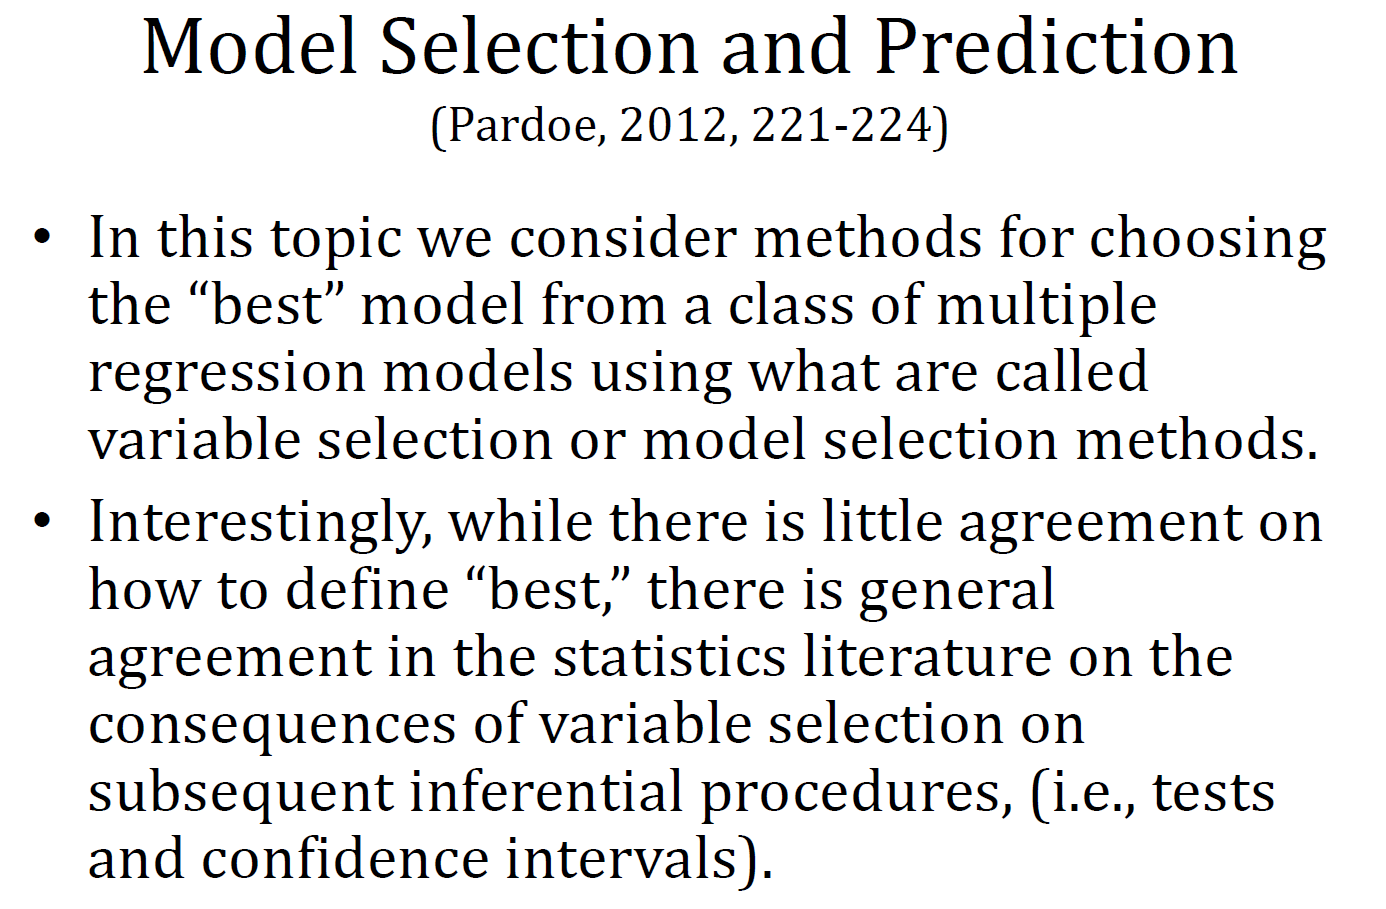

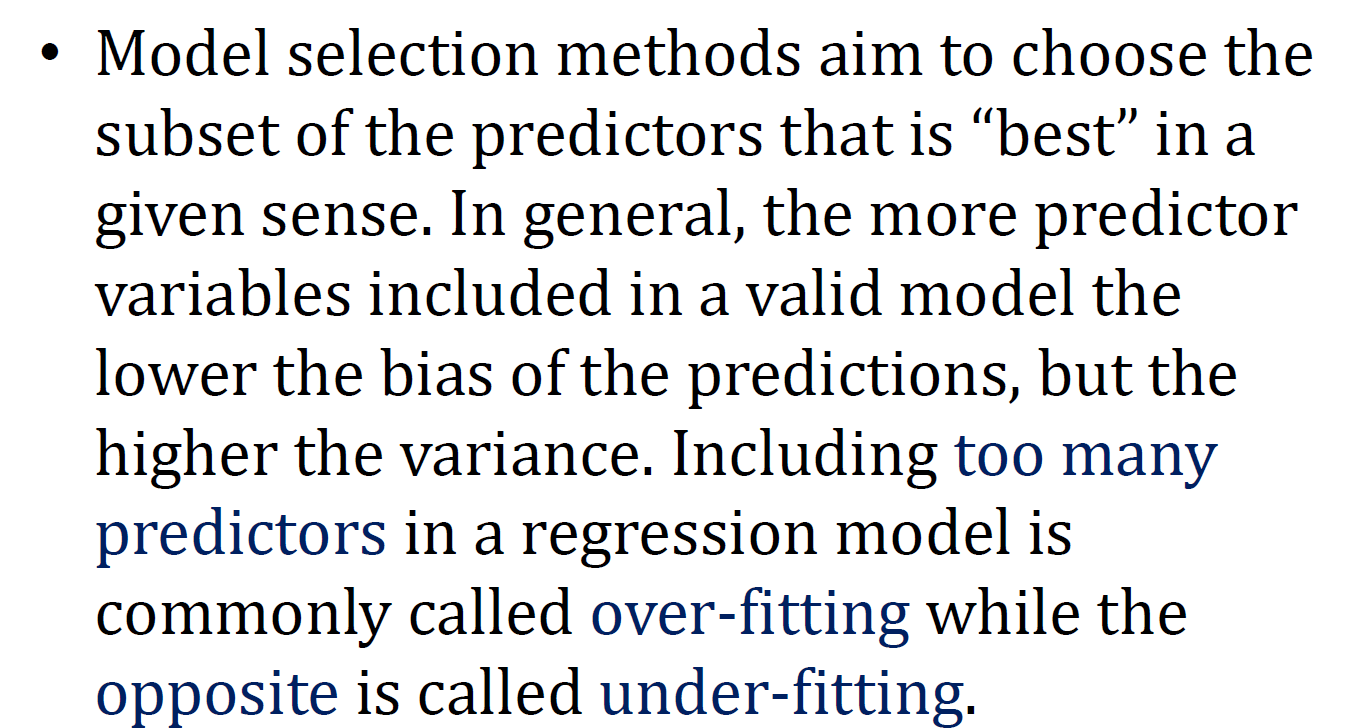

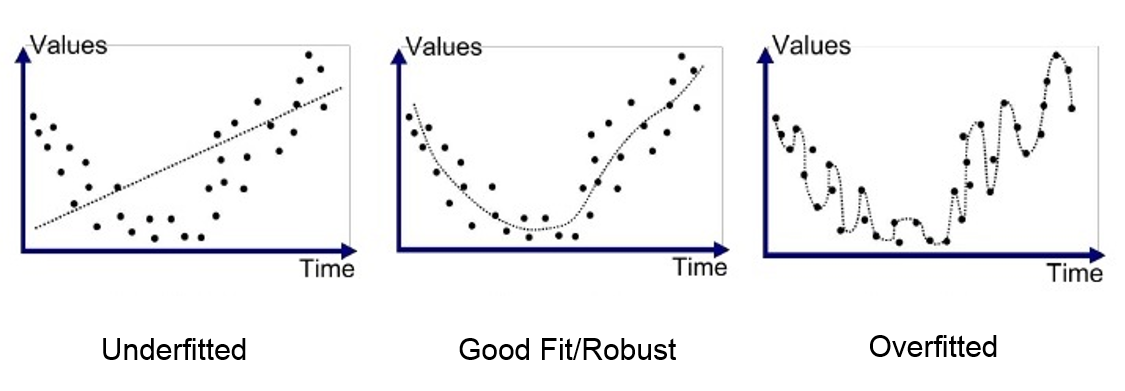

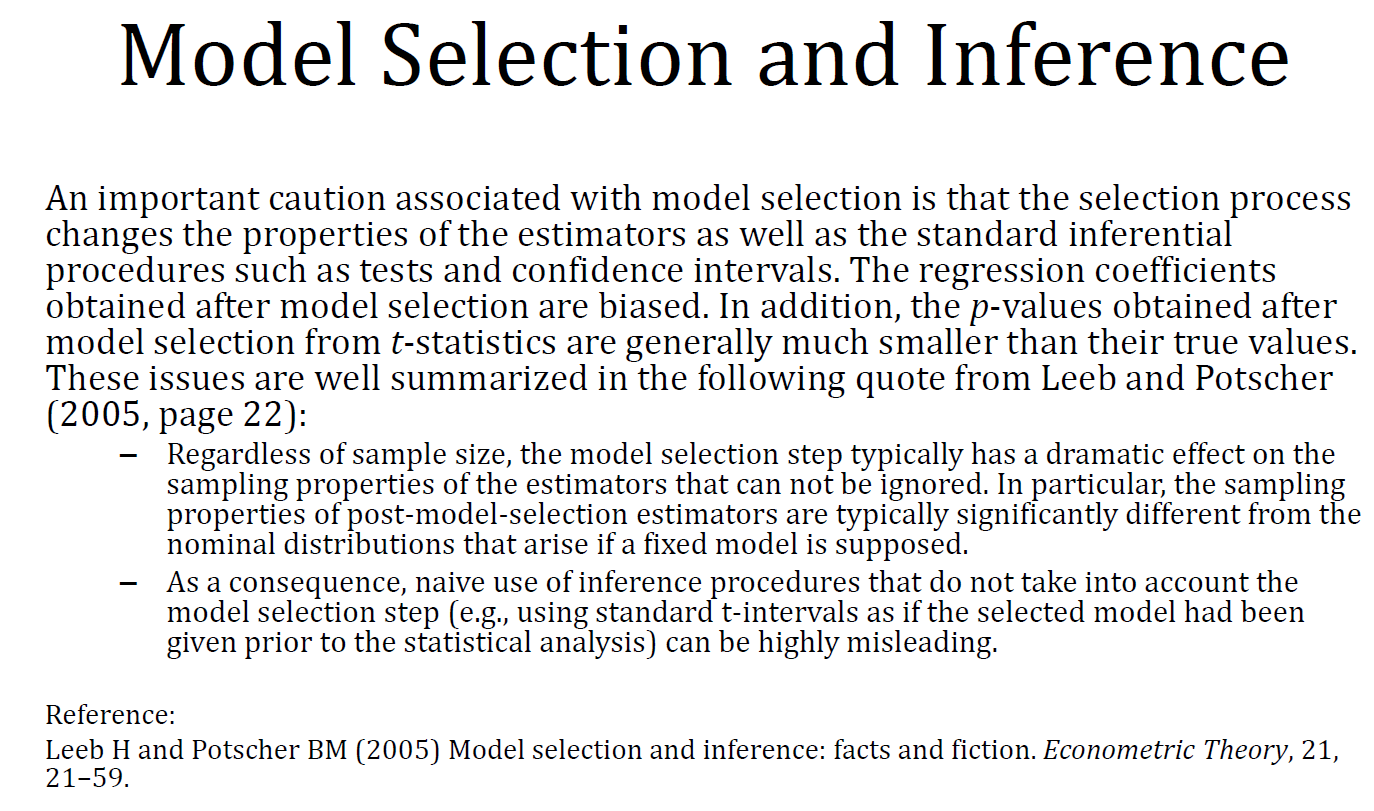

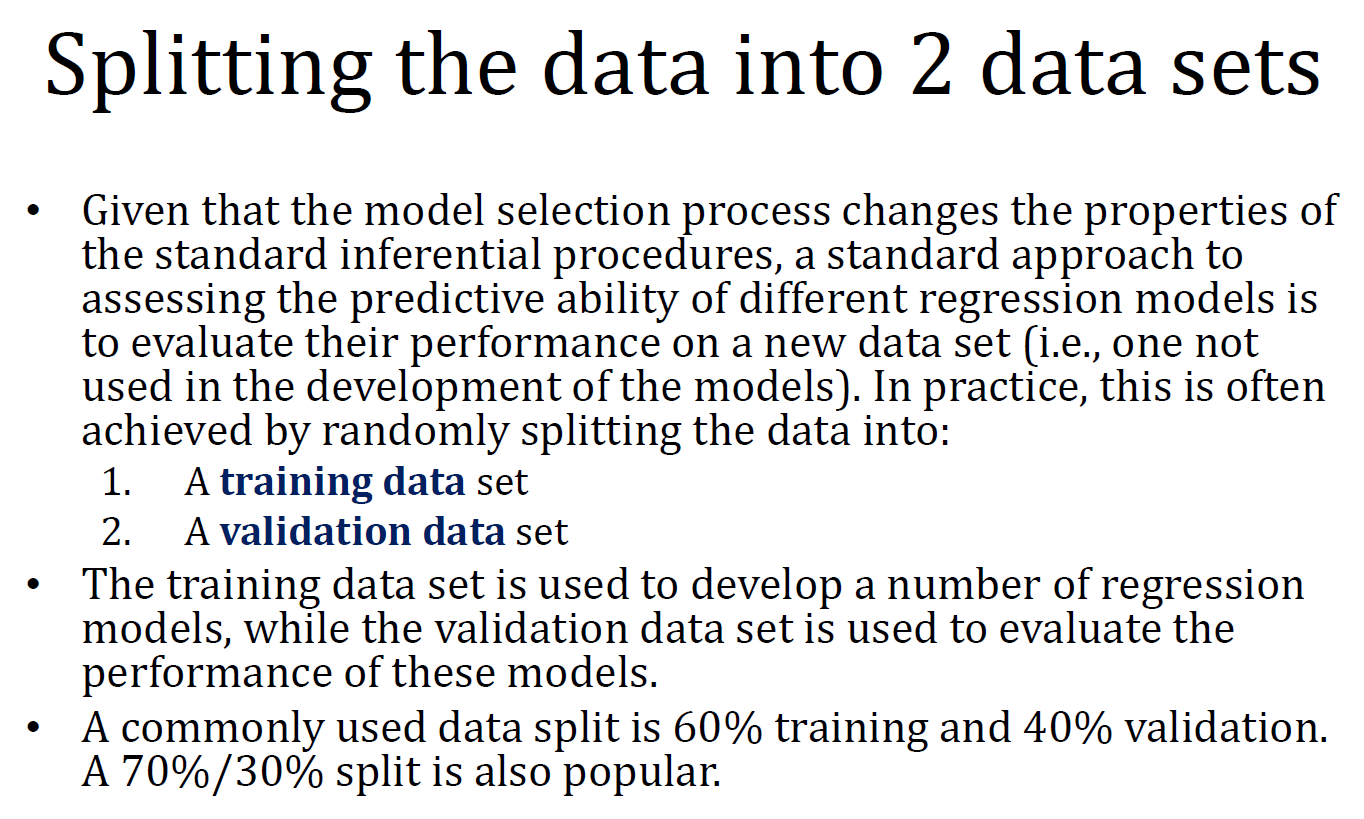

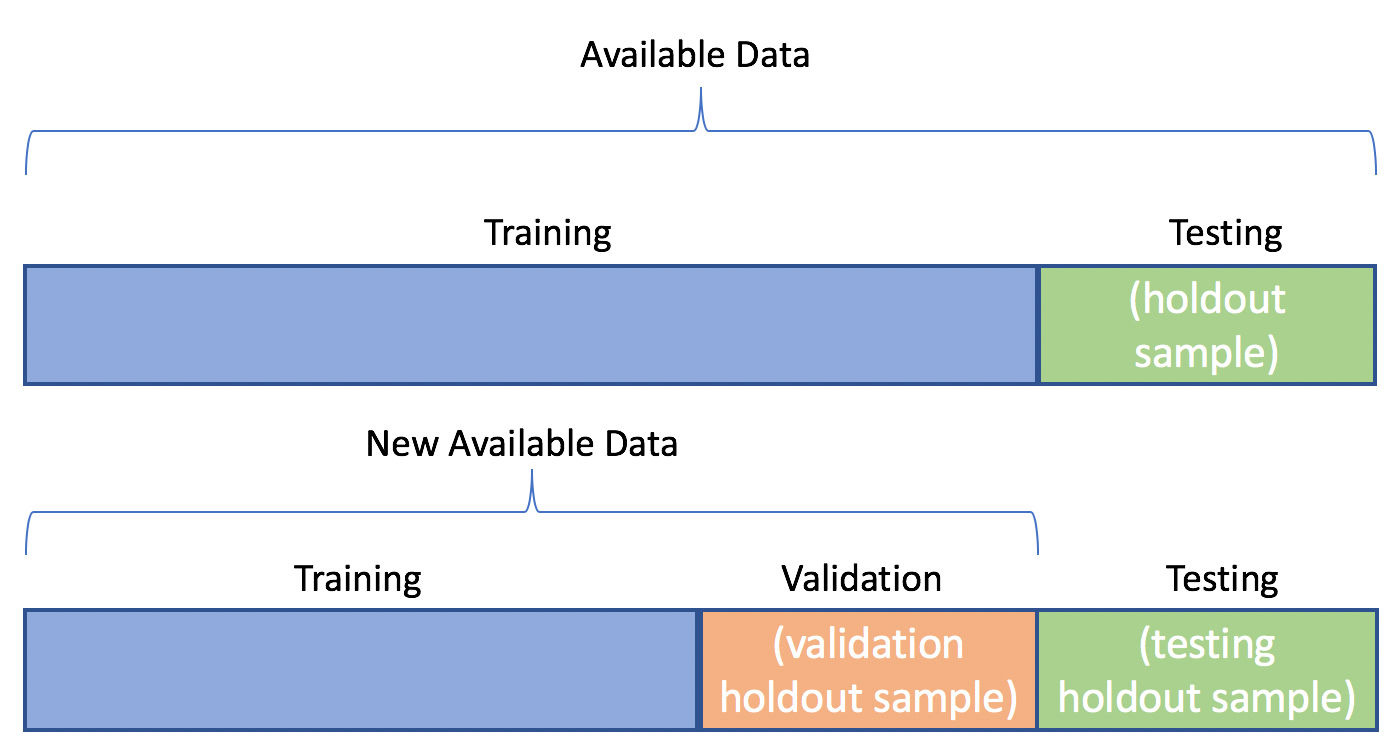

# Modeling Driving Distance on the PGA Tour

## Exercise: We seek to develop a regression model of average driving distance in men's professional golf in 2013.  Data in the form of year to date statitics on the top 180 tour players are available here:


## Data Description

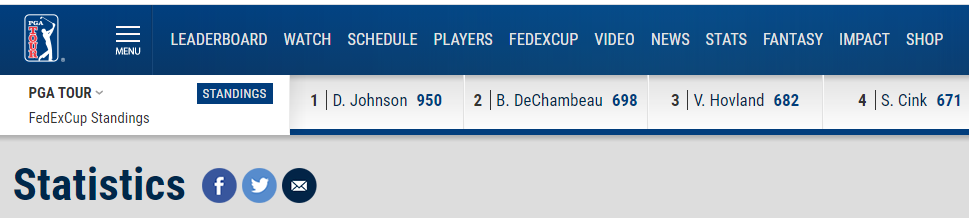

## Variables
- Y, Driving distance which is the average number of yards per measured drive. These drives are measured on two
holes per round. Care is taken to select two holes which face in opposite directions to counteract the effect of
wind. Drives are measured to the point at which they come to rest regardless of whether they are in the fairway or
not.
- x1, Club head speed which is the average speed at which the club impacts the ball (mph) on pars 4 and 5 tee
shots.
- x2, Ball speed which is the average peak speed of the golf ball at launch (mph) on pars 4 and 5 tee shots
- x3, Launch angle which is the average vertical launch angle of the ball immediately after leaving the club on pars
4 and 5 tee shots.
- x4, Spin rate which is the average RPM's of the golf ball immediately after leaving the club on pars 4 and 5 tee
shots.
- x5, Distance to apex which is the average distance (in yards) from the tee to the apex point on pars 4 and 5 tee
shots.
- x6, Apex height which is the average highest point of the shot (in feet) relative to the tee on pars 4 and 5 tee shots.
- x7, Hang time which is the average elapsed time from launch to the point of ground impact on pars 4 and 5 tee
shots.
- x8, Carry distance which is the average distance from tee to the point of ground impact on pars 4 and 5 shots.
- total_num_drives, the number of measured drives that are included in each golfers
average driving distance.

## Get Data

In [35]:
def get_golf_stats_data():
    
    def feet_to_float(cell_string):
        try:
            split_strings = cell_string.replace('"','').replace("'",'').split()
            float_value = float(split_strings[0])+float(split_strings[1])
        except:
            float_value = np.nan
        return float_value
    
    golf_stats = pd.DataFrame()

    golf_stats['player_name'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.101.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['PLAYER NAME'].to_list()
    golf_stats['total_num_drives'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.101.y2013.html')[1][['PLAYER NAME','TOTAL DRIVES']].sort_values('PLAYER NAME')['TOTAL DRIVES'].to_list()
    golf_stats['avg_driving_distance'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.101.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_club_head_speed'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02401.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_ball_speed'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02402.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_launch_angle'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02404.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_spin_rate'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02405.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_distance_to_apex'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02406.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_apex_height'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02407.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.']
    golf_stats['avg_hang_time'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02408.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()
    golf_stats['avg_carry_distance'] = pd.read_html('https://www.pgatour.com/content/pgatour/stats/stat.02409.y2013.html')[1][['PLAYER NAME','AVG.']].sort_values('PLAYER NAME')['AVG.'].to_list()

    golf_stats['avg_apex_height'] = golf_stats['avg_apex_height'].apply(feet_to_float)
    
    return golf_stats

In [36]:
if os.path.exists('./golf_stats.pkl'):
    golf_stats = pd.read_pickle('./golf_stats.pkl')
    print("Yay! It's there!")

else:
    golf_stats = get_golf_stats_data()
    golf_stats.to_pickle('./golf_stats.pkl')
    
print('Length of the dataset is ', len(golf_stats))
golf_stats.head(10)

Yay! It's there!
Length of the dataset is  180


player_name  total_num_drives  avg_driving_distance  \
0     Aaron Baddeley               132                 288.5   
1      Aaron Watkins                88                 277.1   
2         Adam Scott               120                 297.8   
3  Alistair Presnell               114                 284.6   
4      Andres Romero               118                 293.1   
5     Andrew Svoboda                88                 290.1   
6          Ben Crane               116                 281.0   
7         Ben Curtis               114                 274.9   
8         Ben Kohles               142                 279.0   
9          Bill Haas               168                 288.2   

   avg_club_head_speed  avg_ball_speed  avg_launch_angle  avg_spin_rate  \
0               118.89          176.32              9.08         2959.4   
1               106.93          158.44             12.22         2826.8   
2               119.63          177.57              8.82         2828.1   
3               111.83          165.50             11.11         2713.5   
4               114.93          170.01             11.64         2424.9   
5               112.25          165.62             11.07         2799.9   
6               108.29          160.81             12.70         2280.4   
7               108.24          160.32             11.69         2526.4   
8               110.17          161.93             10.62         2915.1   
9               114.86          170.20             10.03         2922.4   

   avg_distance_to_apex  avg_apex_height  avg_hang_time  avg_carry_distance  
0                 194.5            139.0            6.0               282.6  
1                 171.1            127.0            6.2               259.2  
2                 195.9            130.0            6.1               286.0  
3                 179.5            125.0            6.1               270.1  
4                 187.6            122.0            6.0               284.0  
5                 179.8            122.0            6.3               270.5  
6                 175.6            126.0            6.4               267.3  
7                 172.2            125.0            6.0               261.6  
8                 176.8            124.0            6.2               264.3  
9                 188.6            116.0            6.5               278.5

## Plot the predictors against each other.

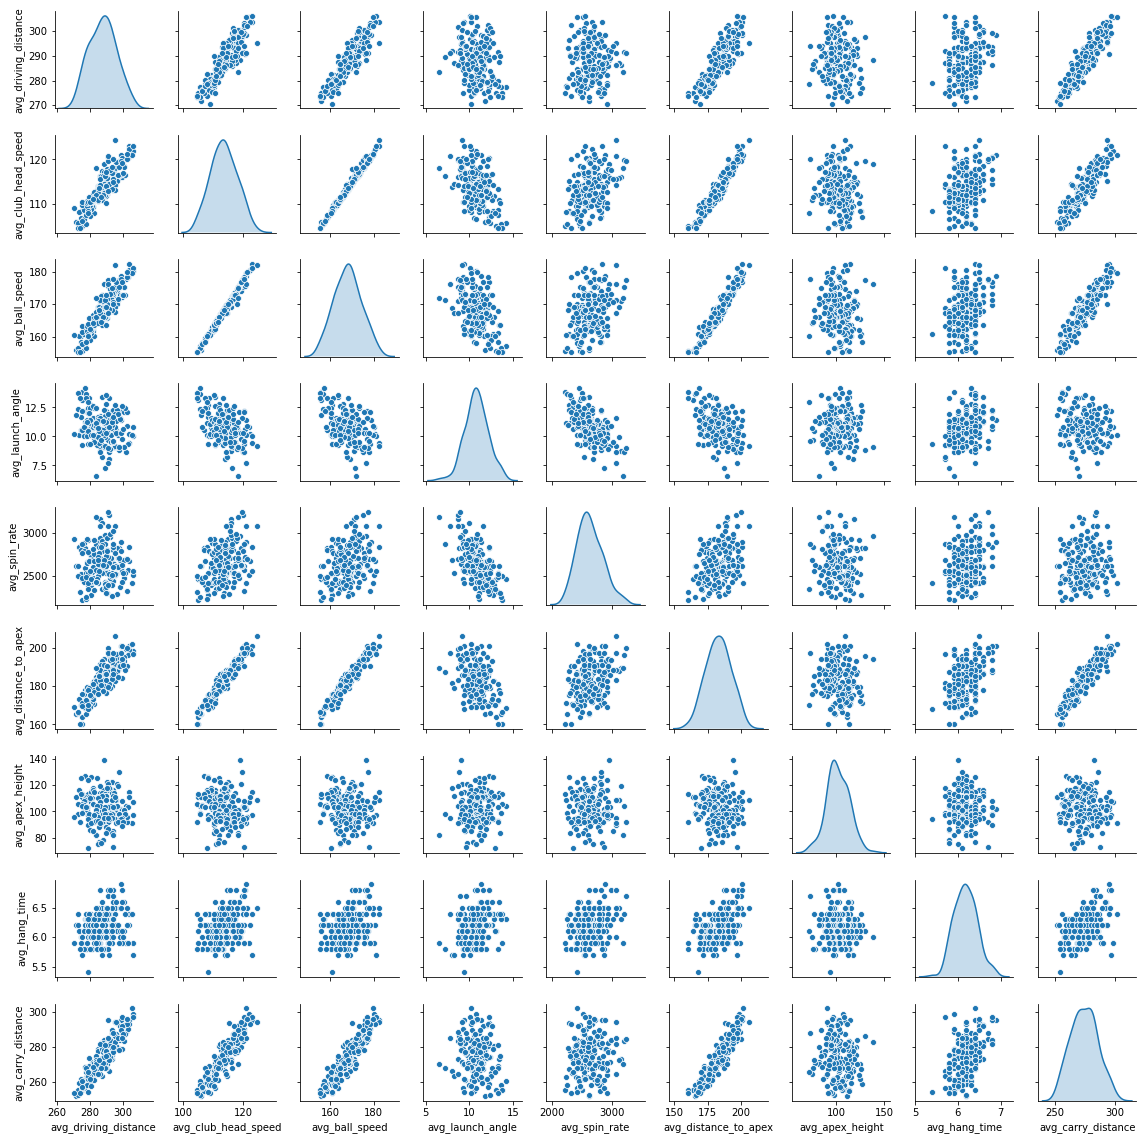

In [37]:
df = golf_stats.copy()

X_plot = df[[col for col in df.columns if col not in ['player_name','total_num_drives']]]

sns.pairplot(X_plot, diag_kind="kde", corner=False, height = 1.75)
plt.show()

- We see that a few of the predictors are at least approximately linearly related to each other
- We do not see any outliers amongs the predictors in either data set
- We see (on the first column) that Y and some of the predictors are at least approximately linearly related 
- We do not see any noticeable outliers

## Next plot the correlations with each other and y

avg_driving_distance  avg_club_head_speed  \
avg_driving_distance              1.000000             0.872833   
avg_club_head_speed               0.872833             1.000000   
avg_ball_speed                    0.892708             0.993062   
avg_launch_angle                 -0.223779            -0.497085   
avg_spin_rate                     0.020138             0.353527   
avg_distance_to_apex              0.846628             0.966040   
avg_apex_height                  -0.098831            -0.130797   
avg_hang_time                     0.247171             0.295507   
avg_carry_distance                0.902400             0.897980   

                      avg_ball_speed  avg_launch_angle  avg_spin_rate  \
avg_driving_distance        0.892708         -0.223779       0.020138   
avg_club_head_speed         0.993062         -0.497085       0.353527   
avg_ball_speed              1.000000         -0.464989       0.310723   
avg_launch_angle           -0.464989          1.000000      -0.593566   
avg_spin_rate               0.310723         -0.593566       1.000000   
avg_distance_to_apex        0.965735         -0.447479       0.365252   
avg_apex_height            -0.128659          0.045266      -0.028672   
avg_hang_time               0.294981          0.308507       0.255362   
avg_carry_distance          0.914974         -0.135692       0.080113   

                      avg_distance_to_apex  avg_apex_height  avg_hang_time  \
avg_driving_distance              0.846628        -0.098831       0.247171   
avg_club_head_speed               0.966040        -0.130797       0.295507   
avg_ball_speed                    0.965735        -0.128659       0.294981   
avg_launch_angle                 -0.447479         0.045266       0.308507   
avg_spin_rate                     0.365252        -0.028672       0.255362   
avg_distance_to_apex              1.000000        -0.096018       0.423068   
avg_apex_height                  -0.096018         1.000000      -0.023864   
avg_hang_time                     0.423068        -0.023864       1.000000   
avg_carry_distance                0.920191        -0.103235       0.464890   

                      avg_carry_distance  
avg_driving_distance            0.902400  
avg_club_head_speed             0.897980  
avg_ball_speed                  0.914974  
avg_launch_angle               -0.135692  
avg_spin_rate                   0.080113  
avg_distance_to_apex            0.920191  
avg_apex_height                -0.103235  
avg_hang_time                   0.464890  
avg_carry_distance              1.000000

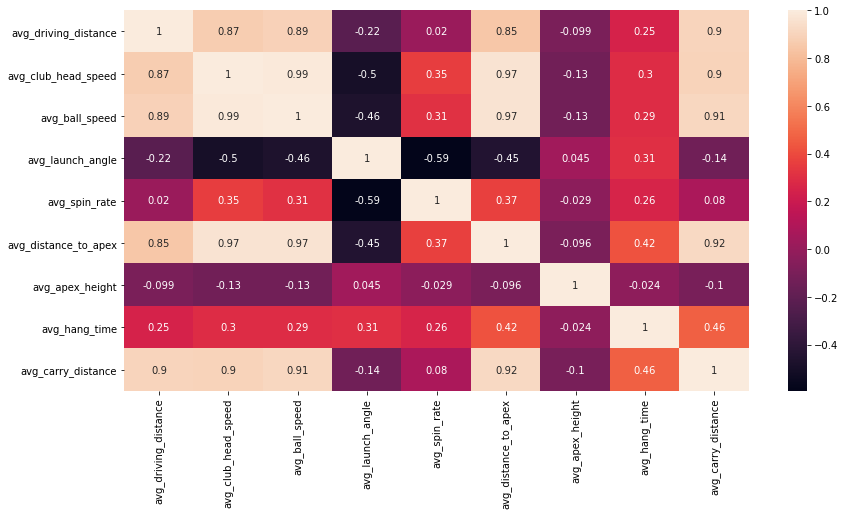

In [38]:

display(X_plot.corr())
plt.figure(figsize = (14,7))
sns.heatmap(X_plot.corr(), annot=True)
plt.show()


## Assign and split the data using a 60/40 split

In [39]:
# assign dataset
df = golf_stats.copy()

# assign y values (outcome variable)
y = df.avg_driving_distance

# assign X values (predictor variables)
X = df[[col for col in df.columns if col not in ['player_name','avg_driving_distance']]]

# display data
display(y.head())

display(X.head())

0    288.5
1    277.1
2    297.8
3    284.6
4    293.1
Name: avg_driving_distance, dtype: float64

total_num_drives  avg_club_head_speed  avg_ball_speed  avg_launch_angle  \
0               132               118.89          176.32              9.08   
1                88               106.93          158.44             12.22   
2               120               119.63          177.57              8.82   
3               114               111.83          165.50             11.11   
4               118               114.93          170.01             11.64   

   avg_spin_rate  avg_distance_to_apex  avg_apex_height  avg_hang_time  \
0         2959.4                 194.5            139.0            6.0   
1         2826.8                 171.1            127.0            6.2   
2         2828.1                 195.9            130.0            6.1   
3         2713.5                 179.5            125.0            6.1   
4         2424.9                 187.6            122.0            6.0   

   avg_carry_distance  
0               282.6  
1               259.2  
2               286.0  
3               270.1  
4               284.0

In [40]:
# split the test and training data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

print('\nPredictors')
print(X_train.shape)
print(X_test.shape)

print('\nTarget')
print(y_train.shape)
print(y_test.shape)


Predictors
(108, 9)
(72, 9)

Target
(108,)
(72,)


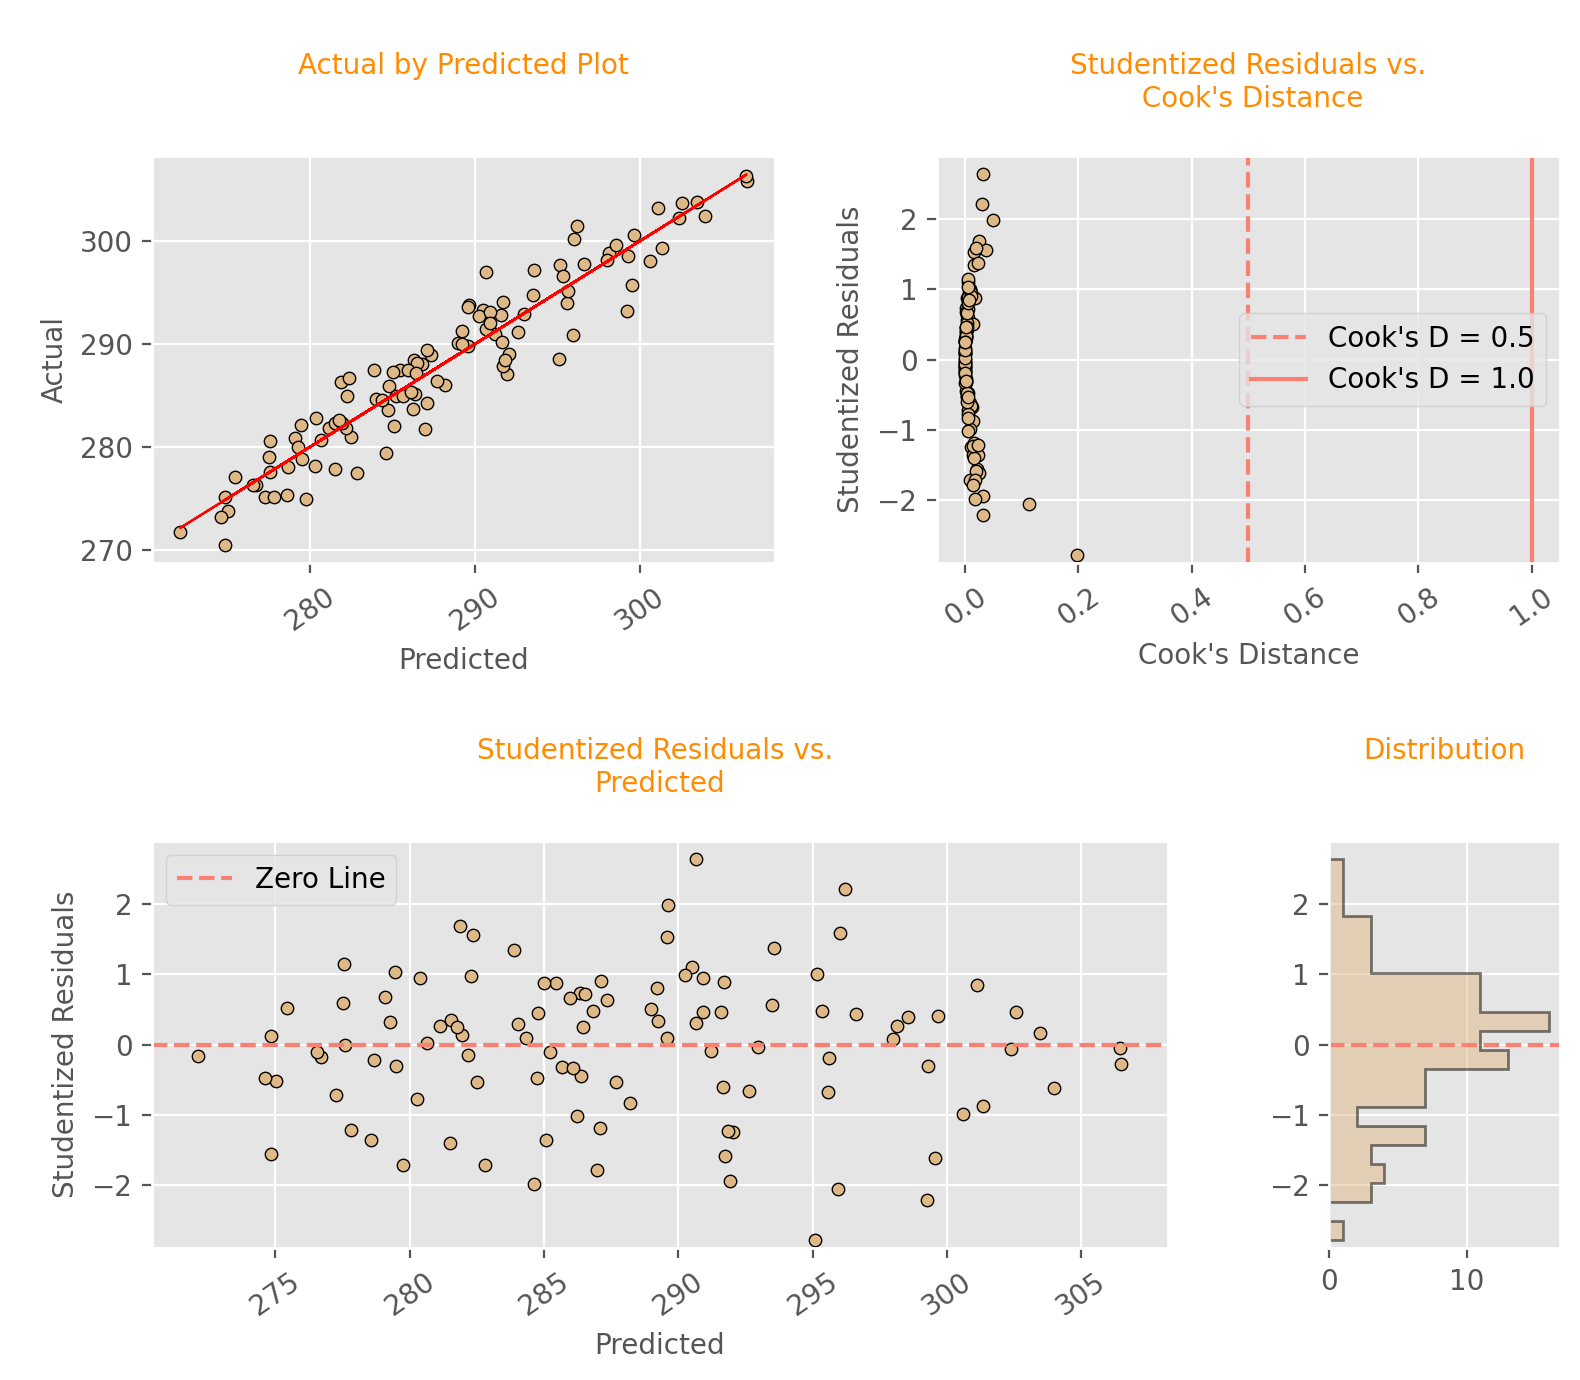

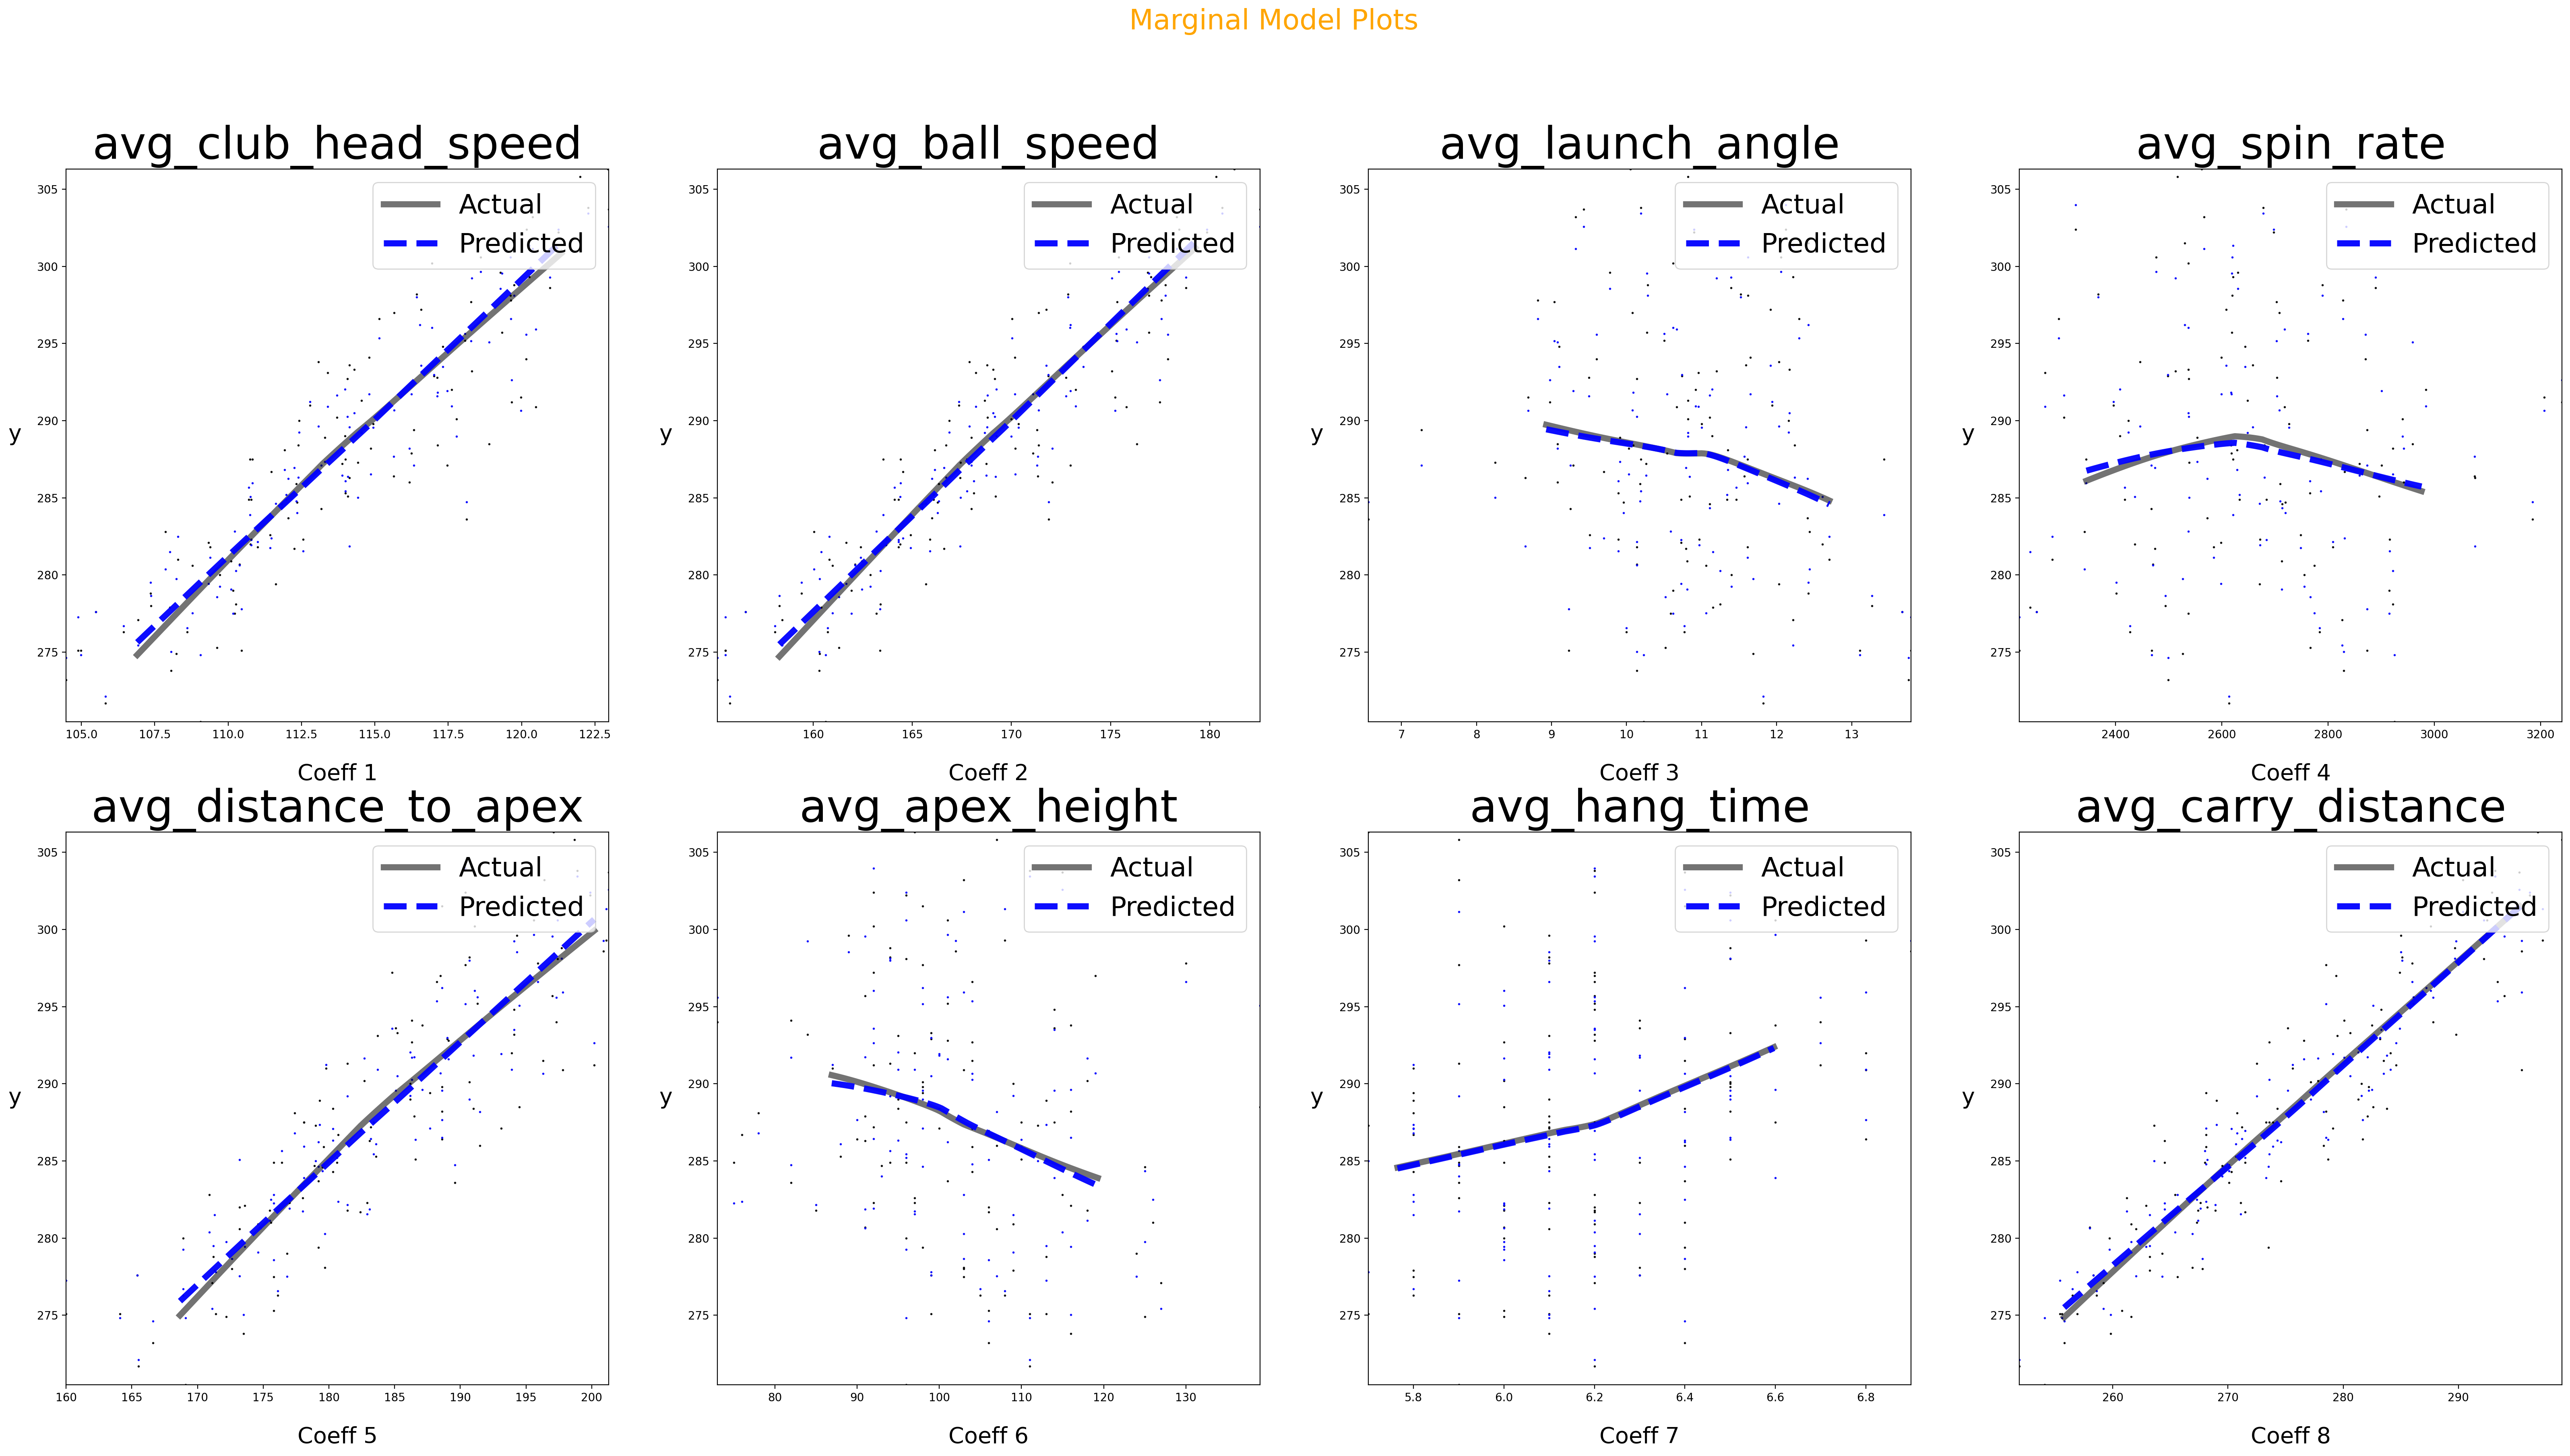

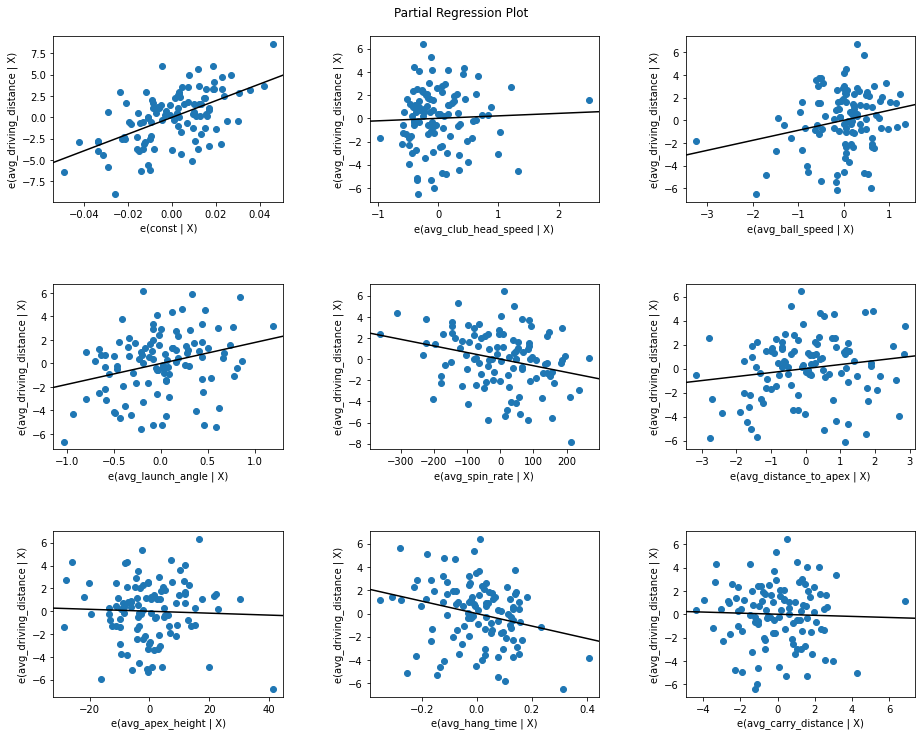

In [41]:
y = y_train.copy()
w = X_train['total_num_drives'].copy()
X = X_train[[col for col in X_train.columns if col != w.name]].copy()

results, fitted_wls_model = wls_regression(
    y,
    X,
    w,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=True,
    display_marginal_model_plots=True,
    return_data=True
)

## Initial Conclusions

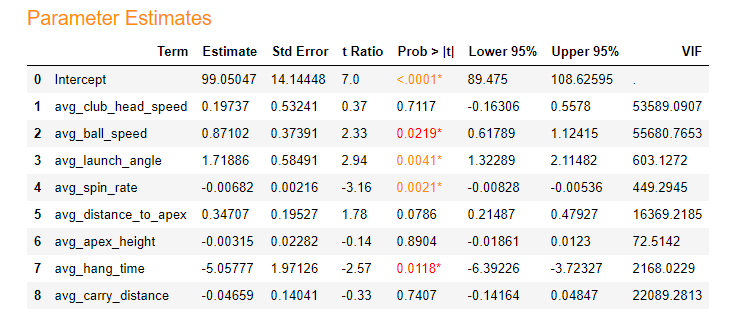

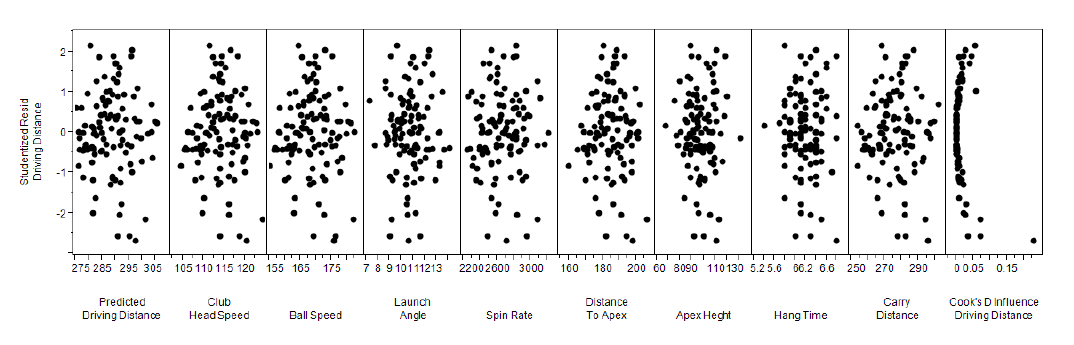

1. Since there are no nonrandom patterns in the plots of the studentized
residuals, the full model which includes all 8 potential predictors is valid.
2. However, since some of the regression coefficients are not statistically
significant and since all 8 of the VIFs are very high, there is some redundancy in
the full model.

Next, we wish to remove some of the predictor variables from the model. How
do we do this? We shall use model selection techniques to do this.

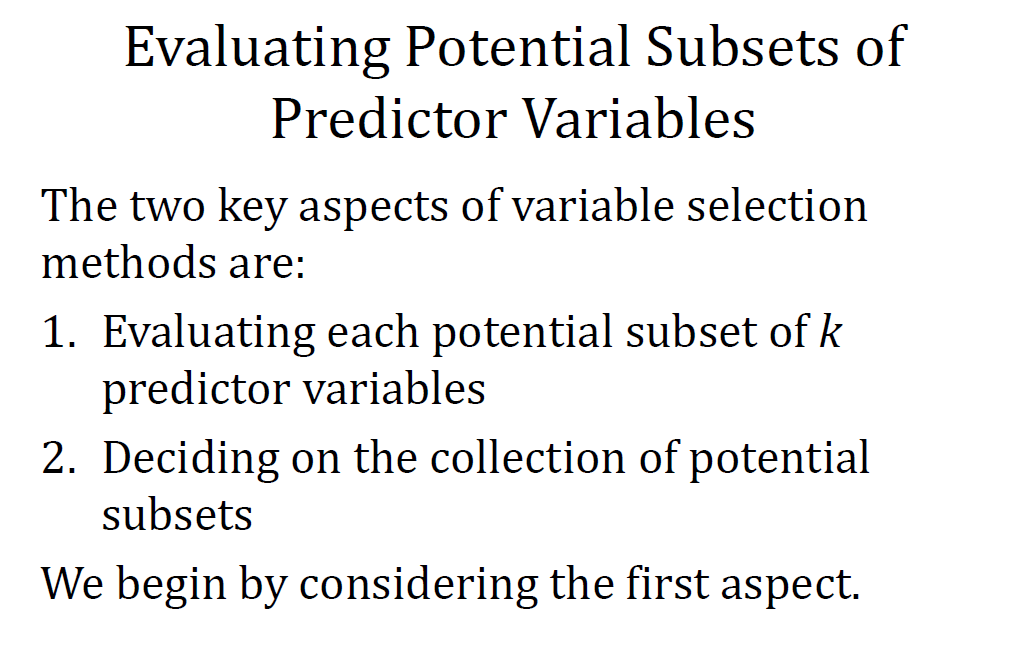

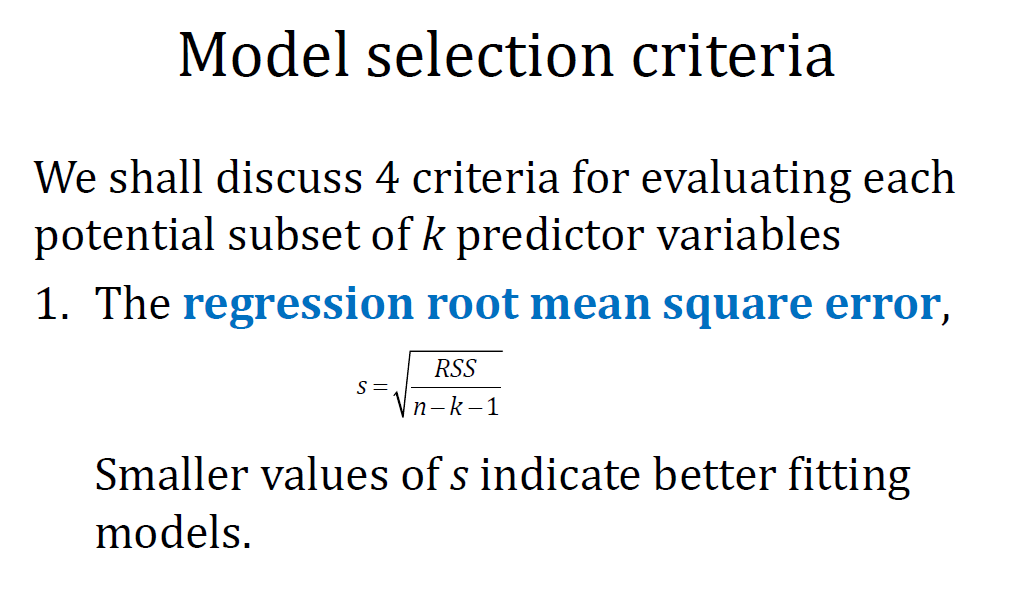

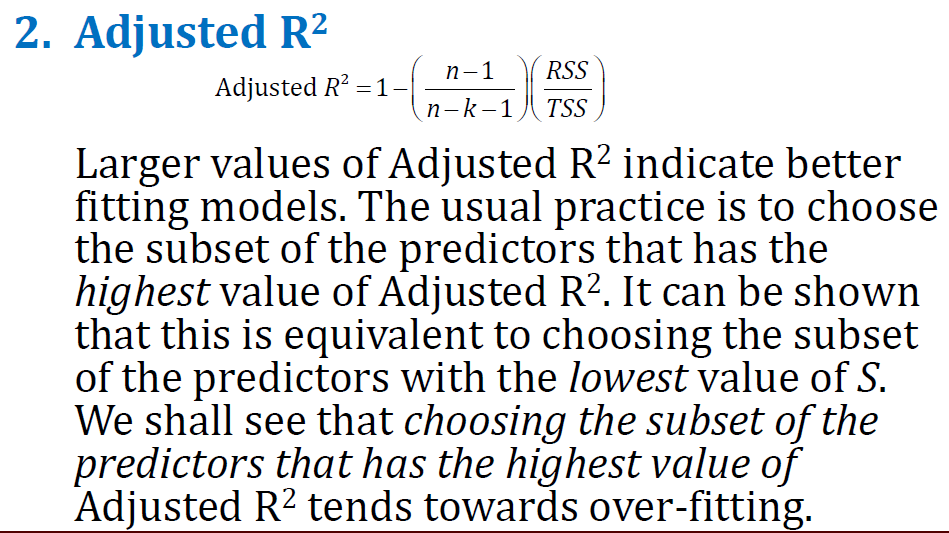

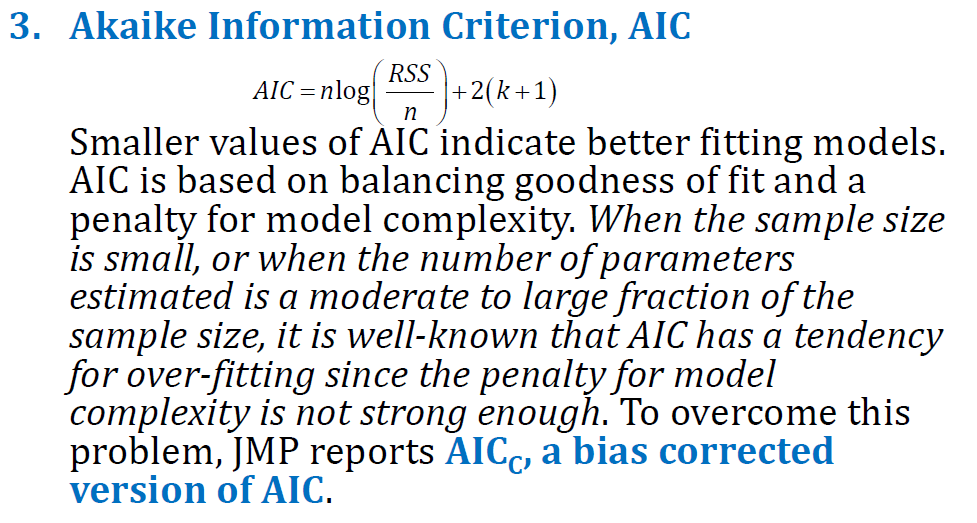

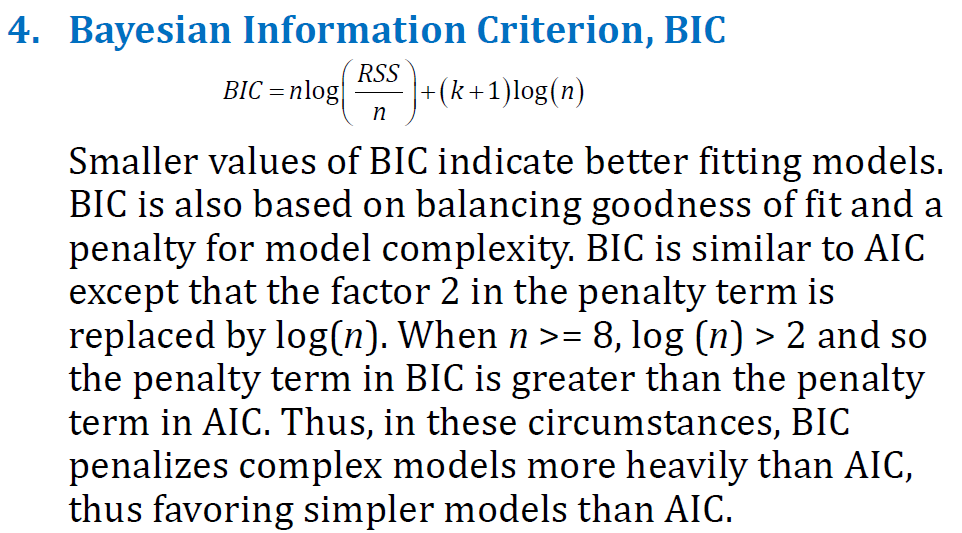

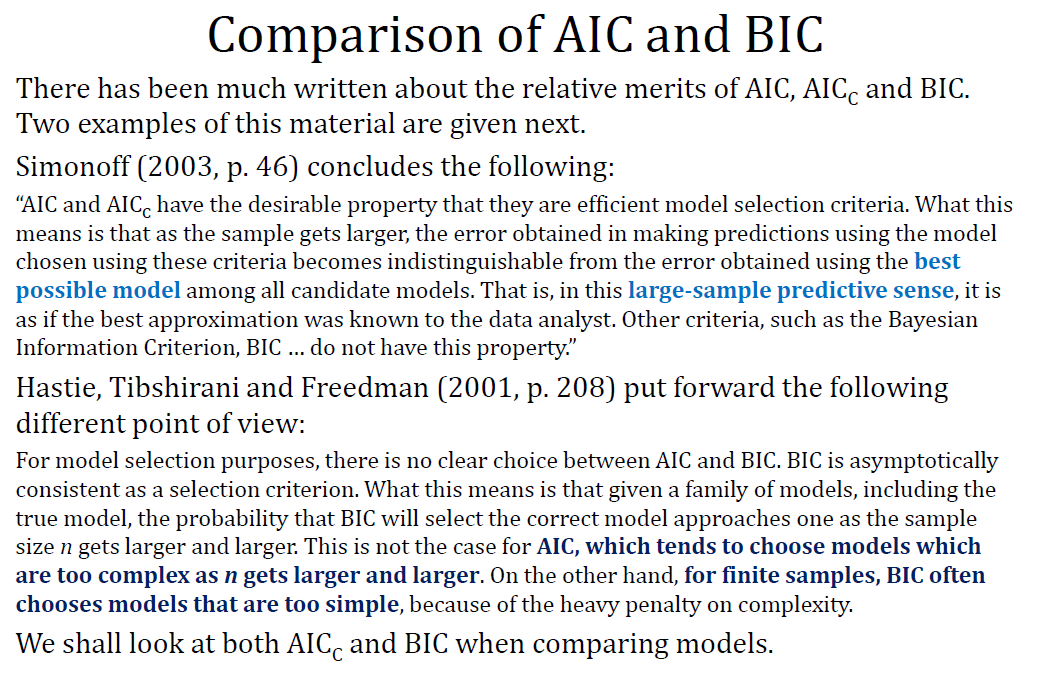

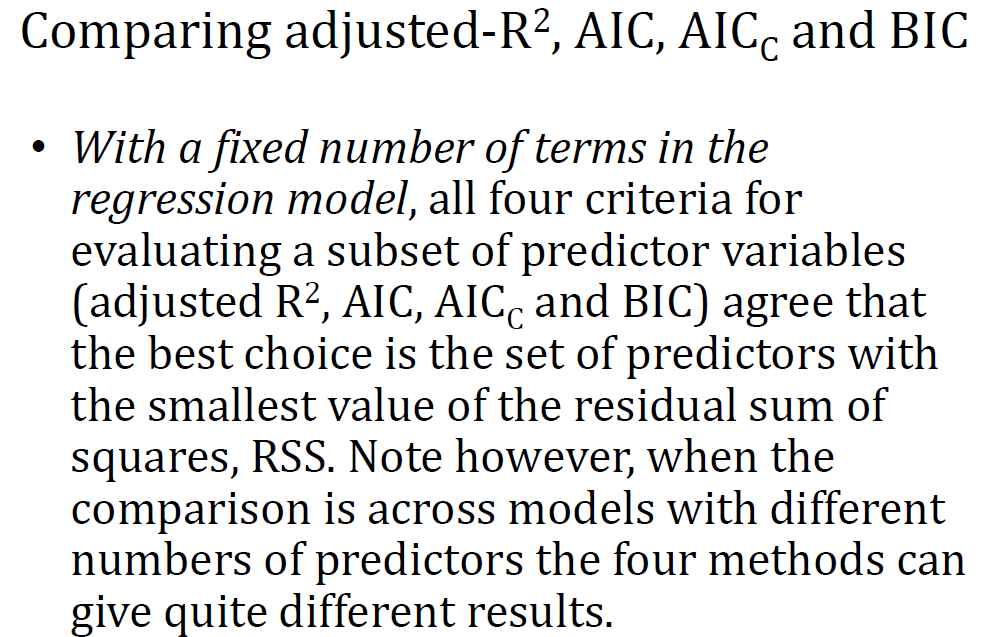

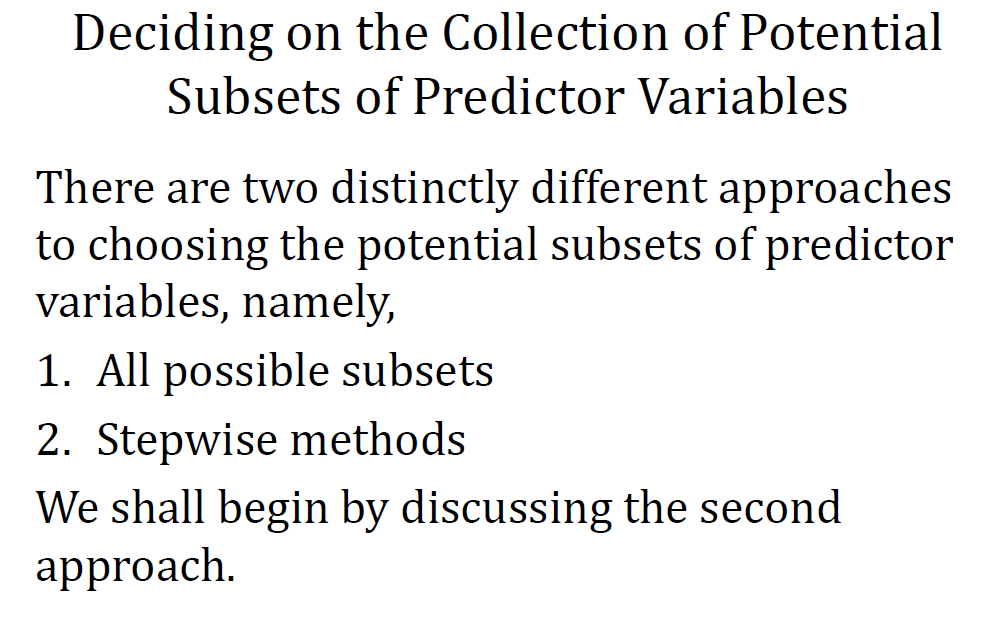

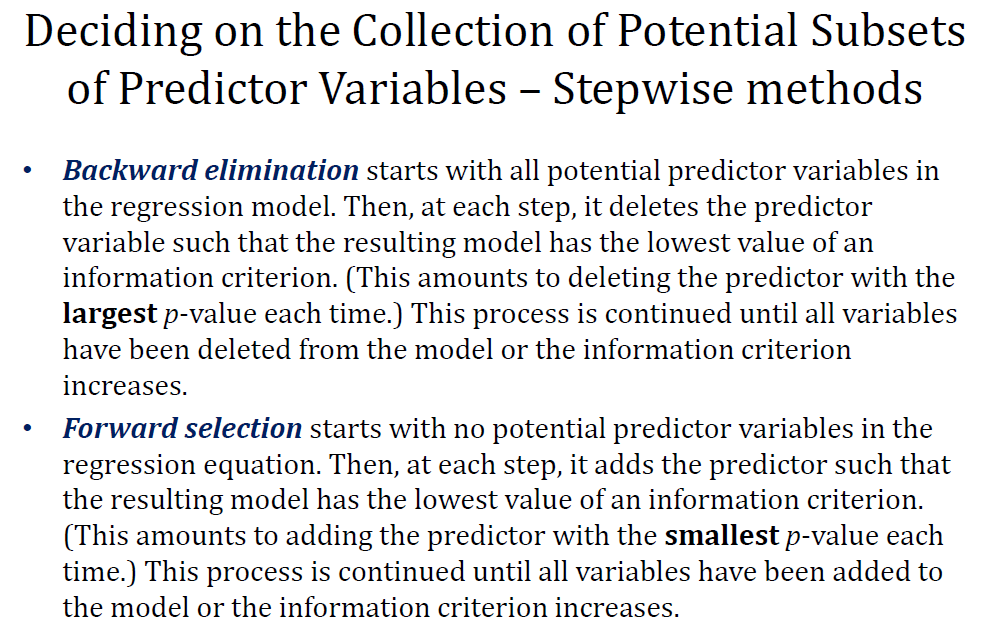

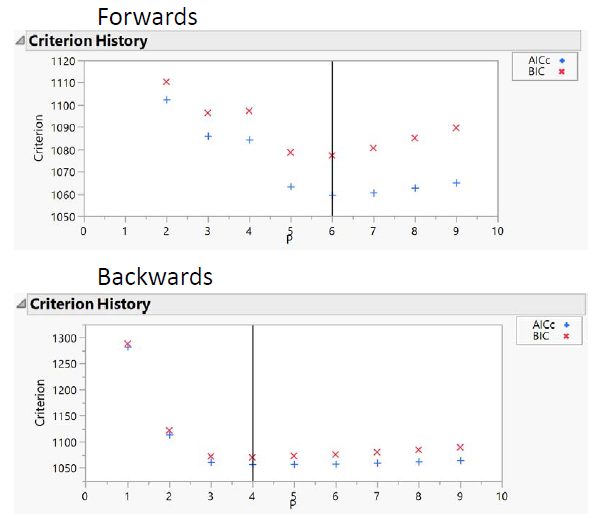

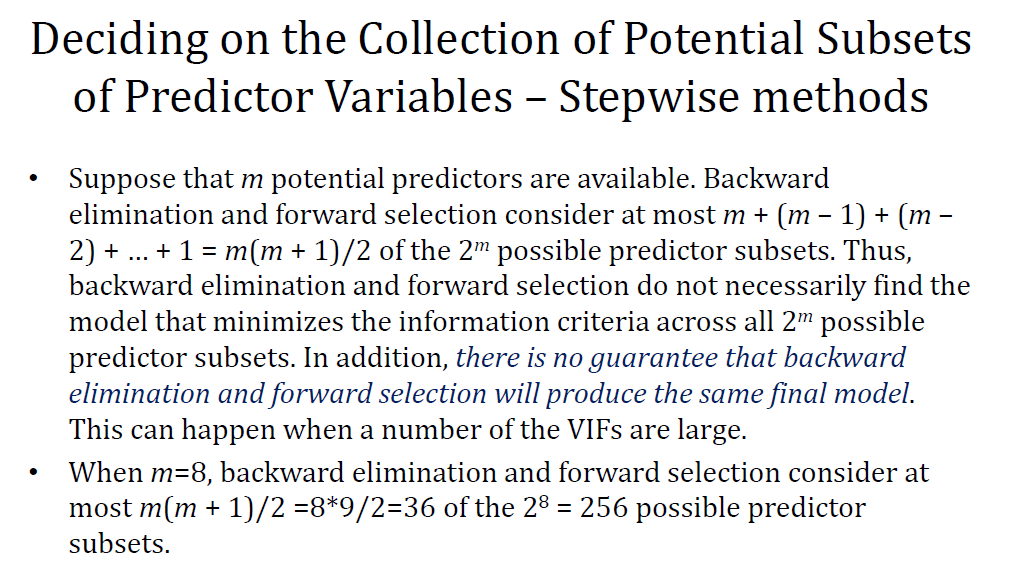

In [42]:
# # assign dataset
# df = golf_stats.copy()

# # assign y values (outcome variable)
# y = df.avg_driving_distance

# # assign X values (predictor variables)
# X = df[[col for col in df.columns if col not in ['player_name','avg_driving_distance']]]

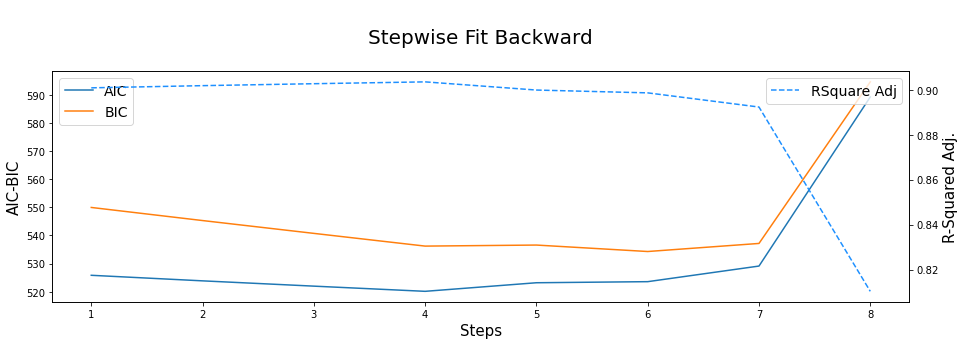

Step             Parameter    Action  Sig Prob         AIC        AICc  \
0     1                   All   Entered  0.890400  525.840186  527.676921   
1     2       avg_apex_height   Removed  0.741154  523.861006  525.315551   
2     3    avg_carry_distance   Removed  0.704910  521.979441  523.099441   
3     4   avg_club_head_speed   Removed  0.029309  520.133555  520.965238   
4     5  avg_distance_to_apex   Removed  0.132429  523.186887  523.775122   
5     6         avg_hang_time   Removed  0.007129  523.572108  523.960458   
6     7      avg_launch_angle   Removed  0.000000  529.126903  529.357672   
7     8         avg_spin_rate   Removed  0.000000  589.301445  589.415730   
8     9                  Best  Specific  0.007129  523.572108  523.960458   

          BIC  RSquare Adj  \
0  549.979367     0.900875   
1  545.318056     0.901847   
2  540.754359     0.902712   
3  536.226342     0.903529   
4  536.597543     0.899889   
5  534.300633     0.898637   
6  537.173297     0.892328   
7  594.665707     0.810328   
8  534.300633     0.898637   

                                                                                        remaining_cols  
0  [avg_club_head_speed, avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_distance_to_apex, avg...  
1  [avg_club_head_speed, avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_distance_to_apex, avg...  
2  [avg_club_head_speed, avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_distance_to_apex, avg...  
3               [avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_distance_to_apex, avg_hang_time]  
4                                     [avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_hang_time]  
5                                                    [avg_ball_speed, avg_launch_angle, avg_spin_rate]  
6                                                                      [avg_ball_speed, avg_spin_rate]  
7                                                                                     [avg_ball_speed]  
8                                                    [avg_ball_speed, avg_launch_angle, avg_spin_rate]

In [43]:
results, fitted_wls_model, step_history = wls_model_selection(
    y,  #target - Average Driving Distance
    X,  #Predictor Variables
    w,  #Number of Drives
    method = 'stepwise_fit_backward', 
    stopping_rule = 'minimum_BIC'
)

In [44]:
step_history

Step             Parameter    Action  Sig Prob         AIC        AICc  \
0     1                   All   Entered  0.890400  525.840186  527.676921   
1     2       avg_apex_height   Removed  0.741154  523.861006  525.315551   
2     3    avg_carry_distance   Removed  0.704910  521.979441  523.099441   
3     4   avg_club_head_speed   Removed  0.029309  520.133555  520.965238   
4     5  avg_distance_to_apex   Removed  0.132429  523.186887  523.775122   
5     6         avg_hang_time   Removed  0.007129  523.572108  523.960458   
6     7      avg_launch_angle   Removed  0.000000  529.126903  529.357672   
7     8         avg_spin_rate   Removed  0.000000  589.301445  589.415730   
8     9                  Best  Specific  0.007129  523.572108  523.960458   

          BIC  RSquare Adj  \
0  549.979367     0.900875   
1  545.318056     0.901847   
2  540.754359     0.902712   
3  536.226342     0.903529   
4  536.597543     0.899889   
5  534.300633     0.898637   
6  537.173297     0.892328   
7  594.665707     0.810328   
8  534.300633     0.898637   

                                                                                        remaining_cols  
0  [avg_club_head_speed, avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_distance_to_apex, avg...  
1  [avg_club_head_speed, avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_distance_to_apex, avg...  
2  [avg_club_head_speed, avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_distance_to_apex, avg...  
3               [avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_distance_to_apex, avg_hang_time]  
4                                     [avg_ball_speed, avg_launch_angle, avg_spin_rate, avg_hang_time]  
5                                                    [avg_ball_speed, avg_launch_angle, avg_spin_rate]  
6                                                                      [avg_ball_speed, avg_spin_rate]  
7                                                                                     [avg_ball_speed]  
8                                                    [avg_ball_speed, avg_launch_angle, avg_spin_rate]

# Iterate through all combinations of models

In [45]:
def all_possible_models(
    y,
    X,
    w,
    num_show = 10,
    min_cols = 1,
    max_cols = len(X.columns),
    stopping_rule = 'bic',
    dislay_results = True,
    pval_max = 0.5,
    vif_max = 10,
    add_intercept=True,
    screen_pvalues=True,
    screen_vifs=True
): 

    
    from itertools import chain, combinations
    from math import comb
    
    def generate_combinations(outcomes, rolls=1):

        # outcome generator developed by AJ Hill

        N = len(outcomes)
        if N == 0 or rolls == 0:
            yield []
            return

        indices = [0 for _ in range(rolls)]

        for i in range(N**rolls):
            yield [outcomes[index] for index in indices]

            for i in range(rolls):
                indices[i] += 1
                if indices[i] == N:
                    indices[i] = 0
                else:
                    break
    
    def find_num_models(total_cols, max_cols, min_cols):

        """
        Takes the maximum number of columns and the minimum number of columns and returns 
        an integer value which represents the number of possible models that can be evaluated.

        Parameters:
        total_cols: A non-negative integer
        max_cols: A non-negative integer
        min_cols: A non-negative integer

        Returns:
        num_models: A non-negative integer

        """
        from math import comb

        upper, lower = 0, 0

        for col_num in range(1, total_cols+1):

            upper += comb(total_cols, col_num)

            if col_num == min_cols-1:
                lower = upper

        num_models = upper - lower     #Add one to account for the same number of max, min, and total columns

        return num_models

    def num_combinatons_powerset(n):

        # Relation to binomial theorem
        # Abs (2^S)

        # https://en.wikipedia.org/wiki/Power_set

        return int(2**n)
    
    def powerset(iterable):
    
        # iterable engine made by AJ Hill
        
        s = list(iterable)
        return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


    min_cols = min_cols-1
    if min_cols < 0:
        min_cols = 0

    cols_list = X.columns.to_list()
    total_cols = len(X.columns.to_list())

    from tqdm.notebook import tqdm_notebook as tqdm
    import math

    if max_cols > total_cols:
        max_cols = total_cols

    total_model_fits = find_num_models(total_cols, max_cols, min_cols)
    total_iterations = num_combinatons_powerset(total_cols)-1

    print('\nAll Possible Models\n')
    print('Total columns/features:          {}'.format(total_cols))
    print('Max coefficients to use:         {}'.format(max_cols))
    print('Min coefficients to use:         {}'.format(min_cols))
    print('Total number of models to fit:   {}'.format(total_model_fits)) 
    print('Number of combinations:          {}'.format(total_iterations))
    print('Number of top models to display: {}'.format(num_show))

    go_no_go = input('\nVERIFICATION:\n\nAre you sure you want fit {} model(s) out of {} possible combinations?\n\n(Yes/No)\n\n'.format(total_model_fits, total_iterations))
    go_no_go = go_no_go.lower()

    if go_no_go.lower == 'no':

        return pd.DataFrame()


    pbar = tqdm(total=total_iterations-1) # display progress...

    sets = list(powerset(cols_list))

    all_models = {}
    model_num = 0

    for cols in sets[1:][::-1]:
        pbar.update(1)

        if len(cols) < min_cols or len(cols) > max_cols:  #screen out columns from max or min
            continue

        X_predictors = X[list(cols)]

        if add_intercept == True:
            X_predictors = sm.add_constant(X_predictors)

        # fitted model
        model_wls = sm.WLS(y, X_predictors, weights=w) # fit model
        fitted_wls = model_wls.fit()

        # screen for pvalues and vifs

        pvalues = list((fitted_wls.pvalues).values)
        vifs = list(get_vifs(X_predictors, add_intercept).values)

        # screen for pvalues
        if screen_pvalues == True and max([0 if np.isnan(val) else val for val in pvalues]) >= pval_max:
                    continue

        # screen for vifs
        if screen_vifs == True and max([0 if np.isnan(val) else val for val in vifs]) > vif_max:
                    continue

        # metrics
        model_num += 1
        num_terms = len(cols)
        coeffs = list((fitted_wls.pvalues).index)

        llf = fitted_wls.llf
        nobs = fitted_wls.nobs
        df_modelwc = len(pvalues)
        aic = fitted_wls.aic
        aicc = sm.tools.eval_measures.aicc(llf, nobs, df_modelwc)
        bic = fitted_wls.bic
        rsquared_adj = fitted_wls.rsquared_adj
        rmse = (
            (mean_squared_error(y,fitted_wls.predict(sm.add_constant(X_predictors))))*0.5 if add_intercept==True
            else (mean_squared_error(y,fitted_wls.predict(X_predictors)))*0.5
        )

        all_models[model_num] = [coeffs, pvalues, vifs, num_terms, aic, aicc, bic, rsquared_adj, rmse]

        # display progress  

    pbar.close()  
    df = pd.DataFrame(all_models).T

    df.columns = ['coeffs', 'pvalues', 'vif', 'num_terms', 'aic', 'aicc', 'bic', 'rsquared_adj', 'rmse']
    df = df.sort_values(by = stopping_rule)
    
    if dislay_results:
        df_display = df[['coeffs', 'num_terms', 'aic', 'aicc', 'bic', 'rsquared_adj', 'rmse']]
        display(df_display.head(num_show))
        
        columns = [feature for feature in df.iloc[0][0] if feature != 'const']
        
        print('\nBest Model Fit Based on {}'.format(stopping_rule.upper()))
        print('\n\nColumns Used:\n')
        
        for col in columns:
            print(col)
        print('\n\n')
        results, fitted_wls_model = wls_regression(
            y,
            X[columns],
            w,
            add_intercept=True,
            display_summary_of_fit=True,
            display_analysis_of_variance=True,
            display_parameter_estimates=True,
            display_diagnostic_plots=True,
            display_leverage_plots=False,
            display_marginal_model_plots=False,
            return_data=True
        )
    
    return df, fitted_wls_model




All Possible Models

Total columns/features:          8
Max coefficients to use:         8
Min coefficients to use:         0
Total number of models to fit:   255
Number of combinations:          255
Number of top models to display: 10

VERIFICATION:

Are you sure you want fit 255 model(s) out of 255 possible combinations?

(Yes/No)

Yes


coeffs num_terms      aic     aicc      bic  \
1    [const, avg_carry_distance]         1  574.926  575.041  580.291   
6        [const, avg_ball_speed]         1  589.301  589.416  594.666   
7   [const, avg_club_head_speed]         1  607.467  607.581  612.831   
4  [const, avg_distance_to_apex]         1   624.71  624.825  630.075   
2         [const, avg_hang_time]         1  761.864  761.978  767.228   
3       [const, avg_apex_height]         1  766.939  767.054  772.304   
5      [const, avg_launch_angle]         1  767.534  767.648  772.898   

  rsquared_adj     rmse  
1     0.833965  5.92545  
6     0.810328  6.47441  
7     0.775585  7.67375  
4     0.736736  9.12049  
2    0.0626118  33.3022  
3    0.0175081  34.1904  
5    0.0120859  34.2746


Best Model Fit Based on BIC


Columns Used:

avg_carry_distance





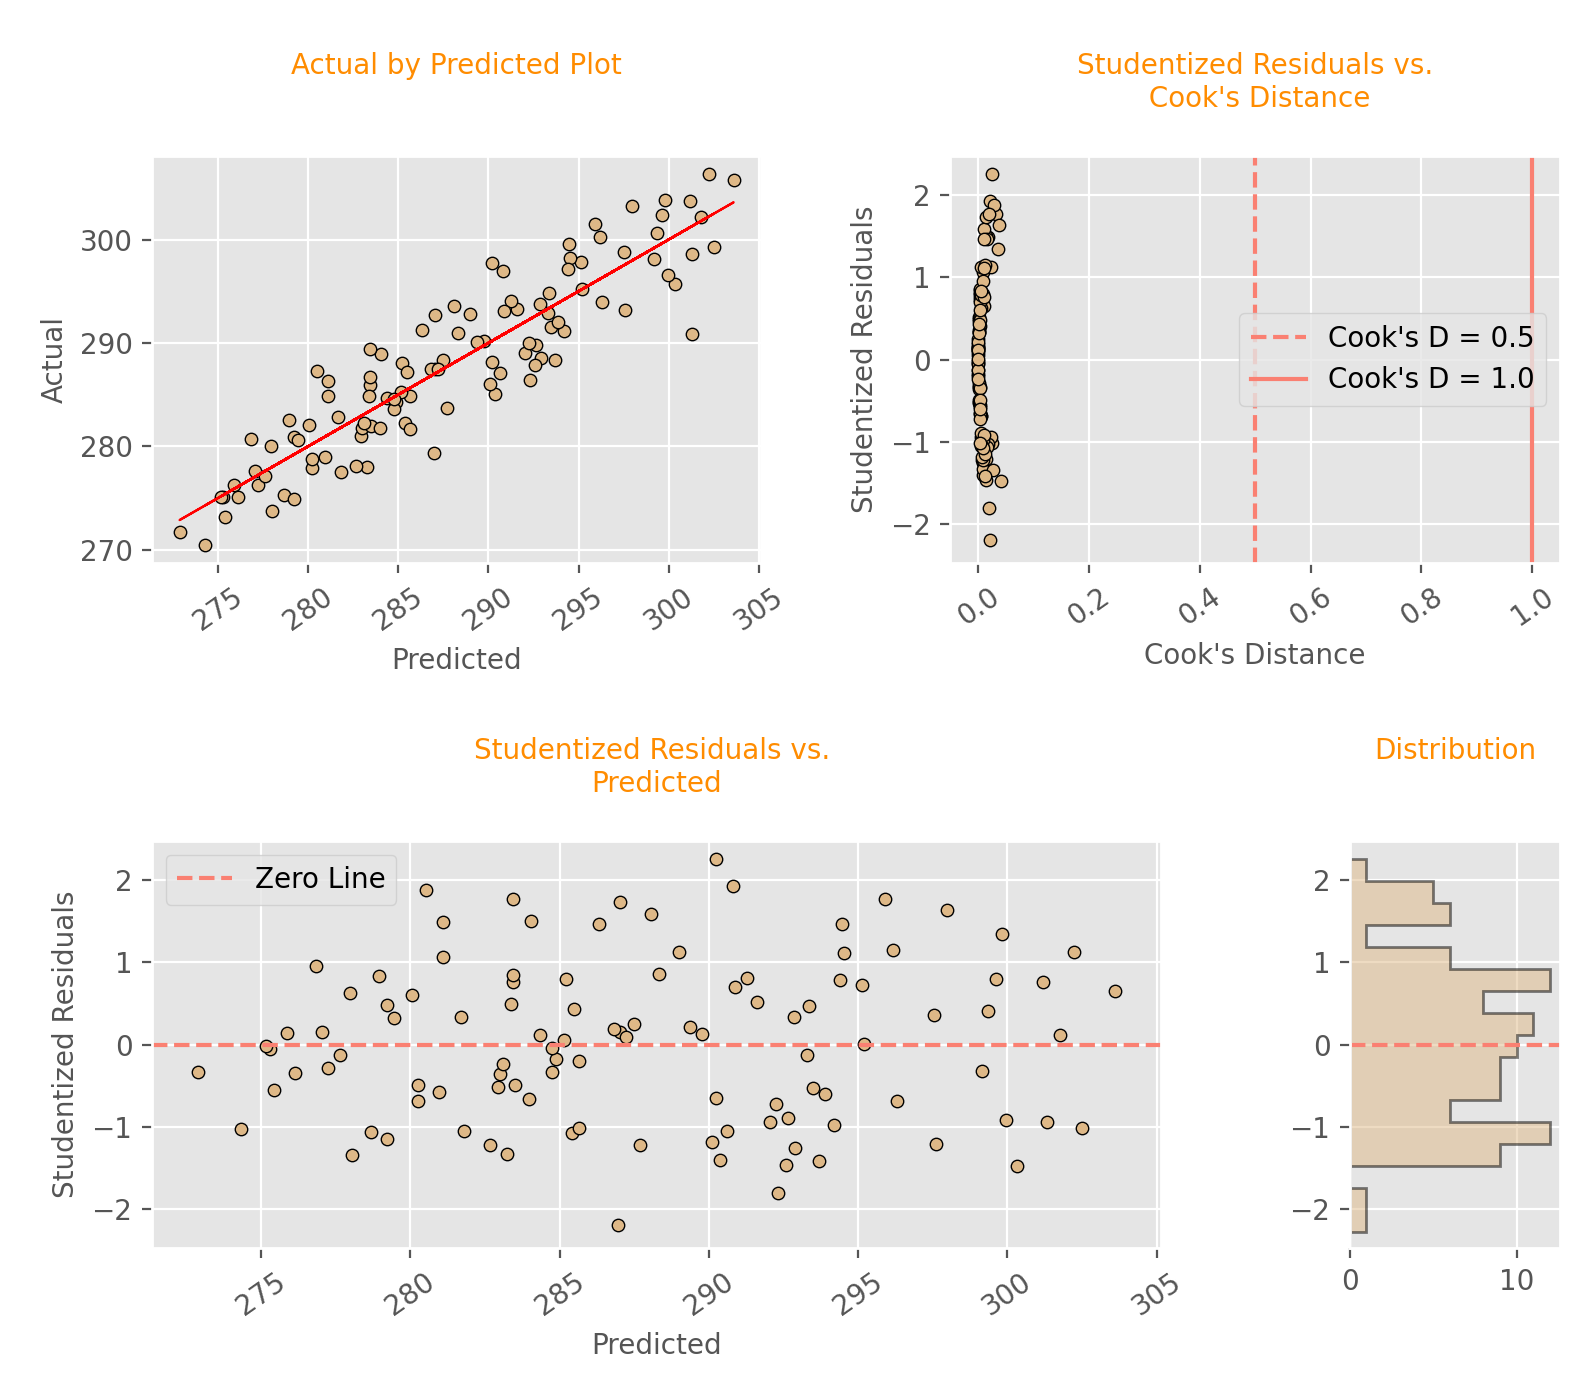

In [46]:
#TODO pring selection criteria here
df, fitted_wls_model = all_possible_models(y, X, w)

# NFL Rushing with 2018 as the training data and 2019 as the test data.

In [47]:
import os

from bs4 import BeautifulSoup
import urllib.request

In [48]:
def find_next_url(url, keyword):

    links = []
    parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
    resp = urllib.request.urlopen(url)
    soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))

    for link in soup.find_all('a', href=True):
        links.append(link['href'])

    next_url = 'https://www.nfl.com'+str([link for link in links if str(keyword) in link][0])
    
    return next_url

def get_players(url, players, letter, keyword):

    #print('Downloading players with last names starting with {} at url: {}'.format(letter, url))
    download = pd.read_html(url)[0]
    objs = [players,download]
    players = pd.concat(objs, axis=0, join='outer', 
                        ignore_index=False, keys=None, levels=None, 
                        names=None, verify_integrity=False, copy=True)    

    # NOTE: recursively iterates to the next URL at the bottom of the page.
    try:
        next_url = find_next_url(url, keyword)
        
        if next_url == 'https://www.nfl.com/players/active/{}?query={}&after='.format(letter,letter):
            return players
        
        else: 
            url = next_url
            players = get_players(url, players, letter, keyword)
        
    except:
        return players
    
    return players

def get_nfl_player_directory(save_to_pickle = True):

    players = pd.DataFrame()

    for letter in [chr(x) for x in range(ord('a'), ord('z') + 1)]:

        #primary url
        url = 'https://www.nfl.com/players/active/{}'.format(letter)
        keyword = 'after'
        players = get_players(url, players, letter, keyword)
    
    if save_to_pickle:
        
        # Save as a pickle file
        players.to_pickle('./nfl_player_directory.pkl')
    
    return players  

def get_player_stats(url, statistics):

    download = pd.read_html(url)[0]
    objs = [statistics,download]
    statistics = pd.concat(objs, axis=0, join='outer', 
                        ignore_index=False, keys=None, levels=None, 
                        names=None, verify_integrity=False, copy=True)    

    # NOTE: recursively iterates to the next URL at the bottom of the page.
    try:

        next_url = find_next_url(url, keyword = 'after')
        statistics = get_player_stats(next_url, statistics)          
        return statistics
    
    except:
        return statistics
    
#    return statistics
    
def get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True):
    
    statistics = pd.DataFrame()
    url = 'https://www.nfl.com/stats/player-stats/category/{}/{}/REG/all/{}/desc'.format(first_category, year, second_category)
    statistics = get_player_stats(url, statistics)
    
    # write the year to the columns
    for col in list(statistics.columns)[1:]:
        statistics = statistics.rename(columns = {col:'{}_{}'.format(col, year)})
    
    if save_to_pickle:
        
        # Save as a pickle file
        statistics.to_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category, year))
    
    return statistics

In [64]:
if os.path.exists('./nfl_player_directory.pkl'):
    nfl_player_directory = pd.read_pickle('./nfl_player_directory.pkl')
    print("Yay! It's there!")

else:
    nfl_player_directory = get_nfl_player_directory(save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_directory))

Yay! It's there!
Length of the dataset is  2877


In [66]:
year = 2015

first_category = 'rushing'
second_category = 'rushingyards'

if os.path.exists('./nfl_player_stats_{}_{}.pkl'.format(first_category,year)):
    nfl_player_stats_rushing_2015 = pd.read_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category,year))
    print("Yay! It's there!")

else:
    nfl_player_stats_rushing_2015 = get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_stats_rushing_2015))


Length of the dataset is  274


In [67]:
year = 2016

first_category = 'rushing'
second_category = 'rushingyards'

if os.path.exists('./nfl_player_stats_{}_{}.pkl'.format(first_category,year)):
    nfl_player_stats_rushing_2016 = pd.read_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category,year))
    print("Yay! It's there!")

else:
    nfl_player_stats_rushing_2016 = get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_stats_rushing_2016))


Length of the dataset is  285


In [65]:
year = 2017

first_category = 'rushing'
second_category = 'rushingyards'

if os.path.exists('./nfl_player_stats_{}_{}.pkl'.format(first_category,year)):
    nfl_player_stats_rushing_2017 = pd.read_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category,year))
    print("Yay! It's there!")

else:
    nfl_player_stats_rushing_2017 = get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_stats_rushing_2017))


Length of the dataset is  284


In [68]:
year = 2018

first_category = 'rushing'
second_category = 'rushingyards'

if os.path.exists('./nfl_player_stats_{}_{}.pkl'.format(first_category,year)):
    nfl_player_stats_rushing_2018 = pd.read_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category,year))
    print("Yay! It's there!")

else:
    nfl_player_stats_rushing_2018 = get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_stats_rushing_2018))

Yay! It's there!
Length of the dataset is  295


In [69]:
year = 2019

first_category = 'rushing'
second_category = 'rushingyards'

if os.path.exists('./nfl_player_stats_{}_{}.pkl'.format(first_category,year)):
    nfl_player_stats_rushing_2019 = pd.read_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category,year))
    print("Yay! It's there!")

else:
    nfl_player_stats_rushing_2019 = get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_stats_rushing_2019))


Yay! It's there!
Length of the dataset is  304


In [70]:
nfl_player_stats_rushing_2017.head()

Player  Rush Yds_2017  Att_2017  TD_2017  20+_2017  40+_2017  \
0   Kareem Hunt           1327       272        8        12         3   
1   Todd Gurley           1305       279       13         8         1   
2  Le'Veon Bell           1291       321        9         3         0   
3  LeSean McCoy           1138       287        6        12         1   
4   Mark Ingram           1124       230       12        11         3   

   Lng_2017  Rush 1st_2017  Rush 1st%_2017  Rush FUM_2017  
0        69             60           4.533              1  
1        57             66           4.227              5  
2        27             74           4.338              2  
3        48             55           5.218              3  
4        72             50           4.600              2

In [71]:
nfl_player_stats_rushing_2018.head()

Player  Rush Yds_2018  Att_2018  TD_2018  20+_2018  40+_2018  \
0  Ezekiel Elliott           1434       304        6        11         1   
1   Saquon Barkley           1307       261       11        16         7   
2      Todd Gurley           1251       256       17        11         0   
3        Joe Mixon           1168       237        8        11         3   
4     Chris Carson           1151       247        9         8         1   

   Lng_2018  Rush 1st_2018  Rush 1st%_2018  Rush FUM_2018  
0        41             73           4.164              6  
1        78             50           5.220              0  
2        36             70           3.657              0  
3        51             60           3.950              0  
4        61             61           4.049              3

In [72]:
nfl_player_stats_rushing_2017 = nfl_player_stats_rushing_2017.set_index('Player')
nfl_player_stats_rushing_2017.head()

Rush Yds_2017  Att_2017  TD_2017  20+_2017  40+_2017  Lng_2017  \
Player                                                                         
Kareem Hunt            1327       272        8        12         3        69   
Todd Gurley            1305       279       13         8         1        57   
Le'Veon Bell           1291       321        9         3         0        27   
LeSean McCoy           1138       287        6        12         1        48   
Mark Ingram            1124       230       12        11         3        72   

              Rush 1st_2017  Rush 1st%_2017  Rush FUM_2017  
Player                                                      
Kareem Hunt              60           4.533              1  
Todd Gurley              66           4.227              5  
Le'Veon Bell             74           4.338              2  
LeSean McCoy             55           5.218              3  
Mark Ingram              50           4.600              2

In [73]:
nfl_player_stats_rushing_2018 = nfl_player_stats_rushing_2018.set_index('Player')
nfl_player_stats_rushing_2018.head()

Rush Yds_2018  Att_2018  TD_2018  20+_2018  40+_2018  \
Player                                                                  
Ezekiel Elliott           1434       304        6        11         1   
Saquon Barkley            1307       261       11        16         7   
Todd Gurley               1251       256       17        11         0   
Joe Mixon                 1168       237        8        11         3   
Chris Carson              1151       247        9         8         1   

                 Lng_2018  Rush 1st_2018  Rush 1st%_2018  Rush FUM_2018  
Player                                                                   
Ezekiel Elliott        41             73           4.164              6  
Saquon Barkley         78             50           5.220              0  
Todd Gurley            36             70           3.657              0  
Joe Mixon              51             60           3.950              0  
Chris Carson           61             61           4.049              3

In [75]:
nfl_player_stats_rushing_2018['points']= (nfl_player_stats_rushing_2018['Rush Yds_2018']/10).astype(int)+nfl_player_stats_rushing_2018['TD_2018']*6-2*nfl_player_stats_rushing_2018['Rush FUM_2018']
nfl_player_stats_rushing_2018['points']

Player
Ezekiel Elliott    167
Saquon Barkley     196
Todd Gurley        227
Joe Mixon          164
Chris Carson       163
                  ... 
Bruce Ellington      0
Trey Burton          0
Akiem Hicks          6
Cameron Batson       0
Ameer Abdullah       0
Name: points, Length: 295, dtype: int64

In [78]:
nfl_player_stats_rushing_2017['target'] = nfl_player_stats_rushing_2018['points']
nfl_player_stats_rushing_2017

Rush Yds_2017  Att_2017  TD_2017  20+_2017  40+_2017  \
Player                                                                  
Kareem Hunt               1327       272        8        12         3   
Todd Gurley               1305       279       13         8         1   
Le'Veon Bell              1291       321        9         3         0   
LeSean McCoy              1138       287        6        12         1   
Mark Ingram               1124       230       12        11         3   
...                        ...       ...      ...       ...       ...   
Lawrence Thomas              1         2        0         0         0   
David Njoku                  1         1        0         0         0   
Braxton Miller               1         1        0         0         0   
Devante Mays                 1         4        0         0         0   
Justin Davis                 1         1        0         0         0   

                 Lng_2017  Rush 1st_2017  Rush 1st%_2017  Rush FUM_2017  \
Player                                                                    
Kareem Hunt            69             60           4.533              1   
Todd Gurley            57             66           4.227              5   
Le'Veon Bell           27             74           4.338              2   
LeSean McCoy           48             55           5.218              3   
Mark Ingram            72             50           4.600              2   
...                   ...            ...             ...            ...   
Lawrence Thomas         1              0           0.000              0   
David Njoku             1              0           0.000              0   
Braxton Miller          1              0           0.000              0   
Devante Mays            2              0           0.000              2   
Justin Davis            1              0           0.000              0   

                 target  
Player                   
Kareem Hunt       124.0  
Todd Gurley       227.0  
Le'Veon Bell        NaN  
LeSean McCoy       69.0  
Mark Ingram        96.0  
...                 ...  
Lawrence Thomas     NaN  
David Njoku         NaN  
Braxton Miller      NaN  
Devante Mays        NaN  
Justin Davis        1.0  

[284 rows x 10 columns]

In [79]:
nfl_player_stats_rushing_2017 = nfl_player_stats_rushing_2017.dropna()
nfl_player_stats_rushing_2017.head()

Rush Yds_2017  Att_2017  TD_2017  20+_2017  40+_2017  Lng_2017  \
Player                                                                          
Kareem Hunt             1327       272        8        12         3        69   
Todd Gurley             1305       279       13         8         1        57   
LeSean McCoy            1138       287        6        12         1        48   
Mark Ingram             1124       230       12        11         3        72   
Jordan Howard           1122       276        9         5         3        53   

               Rush 1st_2017  Rush 1st%_2017  Rush FUM_2017  target  
Player                                                               
Kareem Hunt               60           4.533              1   124.0  
Todd Gurley               66           4.227              5   227.0  
LeSean McCoy              55           5.218              3    69.0  
Mark Ingram               50           4.600              2    96.0  
Jordan Howard             61           4.525              1   143.0

In [98]:
X = nfl_player_stats_rushing_2017[[col for col in nfl_player_stats_rushing_2017.columns if col not in ['target','weight']]]+1
y = nfl_player_stats_rushing_2017['target']+1
nfl_player_stats_rushing_2017['weight'] = 1
w = nfl_player_stats_rushing_2017['weight']


In [99]:
y_log = np.log1p(y)
X_log = np.log1p(X)

In [100]:
X_log

Rush Yds_2017  Att_2017   TD_2017  20+_2017  40+_2017  \
Player                                                                   
Kareem Hunt           7.192182  5.613128  2.302585  2.639057  1.609438   
Todd Gurley           7.175490  5.638355  2.708050  2.302585  1.098612   
LeSean McCoy          7.038784  5.666427  2.079442  2.639057  1.098612   
Mark Ingram           7.026427  5.446737  2.639057  2.564949  1.609438   
Jordan Howard         7.024649  5.627621  2.397895  1.945910  1.609438   
...                        ...       ...       ...       ...       ...   
Isaiah McKenzie       1.791759  1.098612  0.693147  0.693147  0.693147   
Amari Cooper          1.791759  1.098612  0.693147  0.693147  0.693147   
Nick Foles            1.609438  2.564949  0.693147  0.693147  0.693147   
Taylor Heinicke       1.386294  1.098612  0.693147  0.693147  0.693147   
Justin Davis          1.098612  1.098612  0.693147  0.693147  0.693147   

                 Lng_2017  Rush 1st_2017  Rush 1st%_2017  Rush FUM_2017  
Player                                                                   
Kareem Hunt      4.262680       4.127134        1.876866       1.098612  
Todd Gurley      4.077537       4.219508        1.828895       1.945910  
LeSean McCoy     3.912023       4.043051        1.976578       1.609438  
Mark Ingram      4.304065       3.951244        1.887070       1.386294  
Jordan Howard    4.007333       4.143135        1.875641       1.098612  
...                   ...            ...             ...            ...  
Isaiah McKenzie  1.791759       0.693147        0.693147       0.693147  
Amari Cooper     1.791759       1.098612        1.098612       0.693147  
Nick Foles       2.397895       1.098612        2.564949       1.609438  
Taylor Heinicke  1.386294       0.693147        0.693147       0.693147  
Justin Davis     1.098612       0.693147        0.693147       0.693147  

[176 rows x 9 columns]

In [101]:
y.unique()

array([125., 228.,  70.,  97., 144., 149.,  74.,  53., 168.,  78.,  71.,
        84.,  56., 128.,  35.,   7., 105.,  94.,  31.,  69., 178., 173.,
         2., 103., 165.,   4.,  30.,  32.,  65.,   1.,  51., 143.,  24.,
        98.,  40., 119., 148.,  15., 116.,  91.,   3.,  43.,  59.,  17.,
        21.,  37.,  34.,  42.,  10.,  25.,  16.,  18.,  28.,  23.,   6.,
        80.,  62.,  46.,   5.,  22.,  76.,  19., 164.,  48.,  11.,  73.,
         9.,  27.,  29.,  13.,  20.,   8.,   0.,  26.,  14.,  45.,  12.,
       133.,  36.])

In [102]:
y_log.unique()

array([4.83628191, 5.433722  , 4.26267988, 4.58496748, 4.97673374,
       5.01063529, 4.31748811, 3.98898405, 5.12989871, 4.36944785,
       4.27666612, 4.44265126, 4.04305127, 4.8598124 , 3.58351894,
       2.07944154, 4.66343909, 4.55387689, 3.4657359 , 4.24849524,
       5.18738581, 5.1590553 , 1.09861229, 4.6443909 , 5.11198779,
       1.60943791, 3.4339872 , 3.49650756, 4.18965474, 0.69314718,
       3.95124372, 4.9698133 , 3.21887582, 4.59511985, 3.71357207,
       4.78749174, 5.00394631, 2.77258872, 4.76217393, 4.52178858,
       1.38629436, 3.78418963, 4.09434456, 2.89037176, 3.09104245,
       3.63758616, 3.55534806, 3.76120012, 2.39789527, 3.25809654,
       2.83321334, 2.94443898, 3.36729583, 3.17805383, 1.94591015,
       4.39444915, 4.14313473, 3.8501476 , 1.79175947, 3.13549422,
       4.34380542, 2.99573227, 5.10594547, 3.8918203 , 2.48490665,
       4.30406509, 2.30258509, 3.33220451, 3.40119738, 2.63905733,
       3.04452244, 2.19722458, 0.        , 3.29583687, 2.70805


All Possible Models

Total columns/features:          9
Max coefficients to use:         8
Min coefficients to use:         0
Total number of models to fit:   511
Number of combinations:          511
Number of top models to display: 10

VERIFICATION:

Are you sure you want fit 511 model(s) out of 511 possible combinations?

(Yes/No)

Yes


coeffs num_terms      aic  \
18                            [const, Rush Yds_2017]         1    515.1   
17                                 [const, Att_2017]         1  516.529   
9                   [const, Att_2017, Rush FUM_2017]         2  517.503   
12                            [const, Rush 1st_2017]         1   535.21   
2             [const, Rush 1st_2017, Rush 1st%_2017]         2  534.715   
7                         [const, TD_2017, Lng_2017]         2  535.451   
13                                 [const, Lng_2017]         1  540.598   
1   [const, 20+_2017, Rush 1st%_2017, Rush FUM_2017]         3   536.47   
3                   [const, Lng_2017, Rush FUM_2017]         2  540.611   
15                                 [const, 20+_2017]         1  544.329   

       aicc      bic rsquared_adj      rmse  
18   515.17  521.441      0.48906  0.534168  
17  516.599   522.87     0.484895  0.538522  
9   517.643  527.015     0.484928  0.535393  
12  535.279  541.551     0.427216  0.598824  
2   534.854  544.226     0.432013  0.590396  
7   535.591  544.963     0.429632   0.59287  
13  540.667  546.939      0.40941  0.617439  
1   536.704  549.152     0.429505  0.589575  
3    540.75  550.122     0.412664  0.610508  
15  544.398   550.67     0.396756  0.630669


Best Model Fit Based on BIC


Columns Used:

Rush Yds_2017





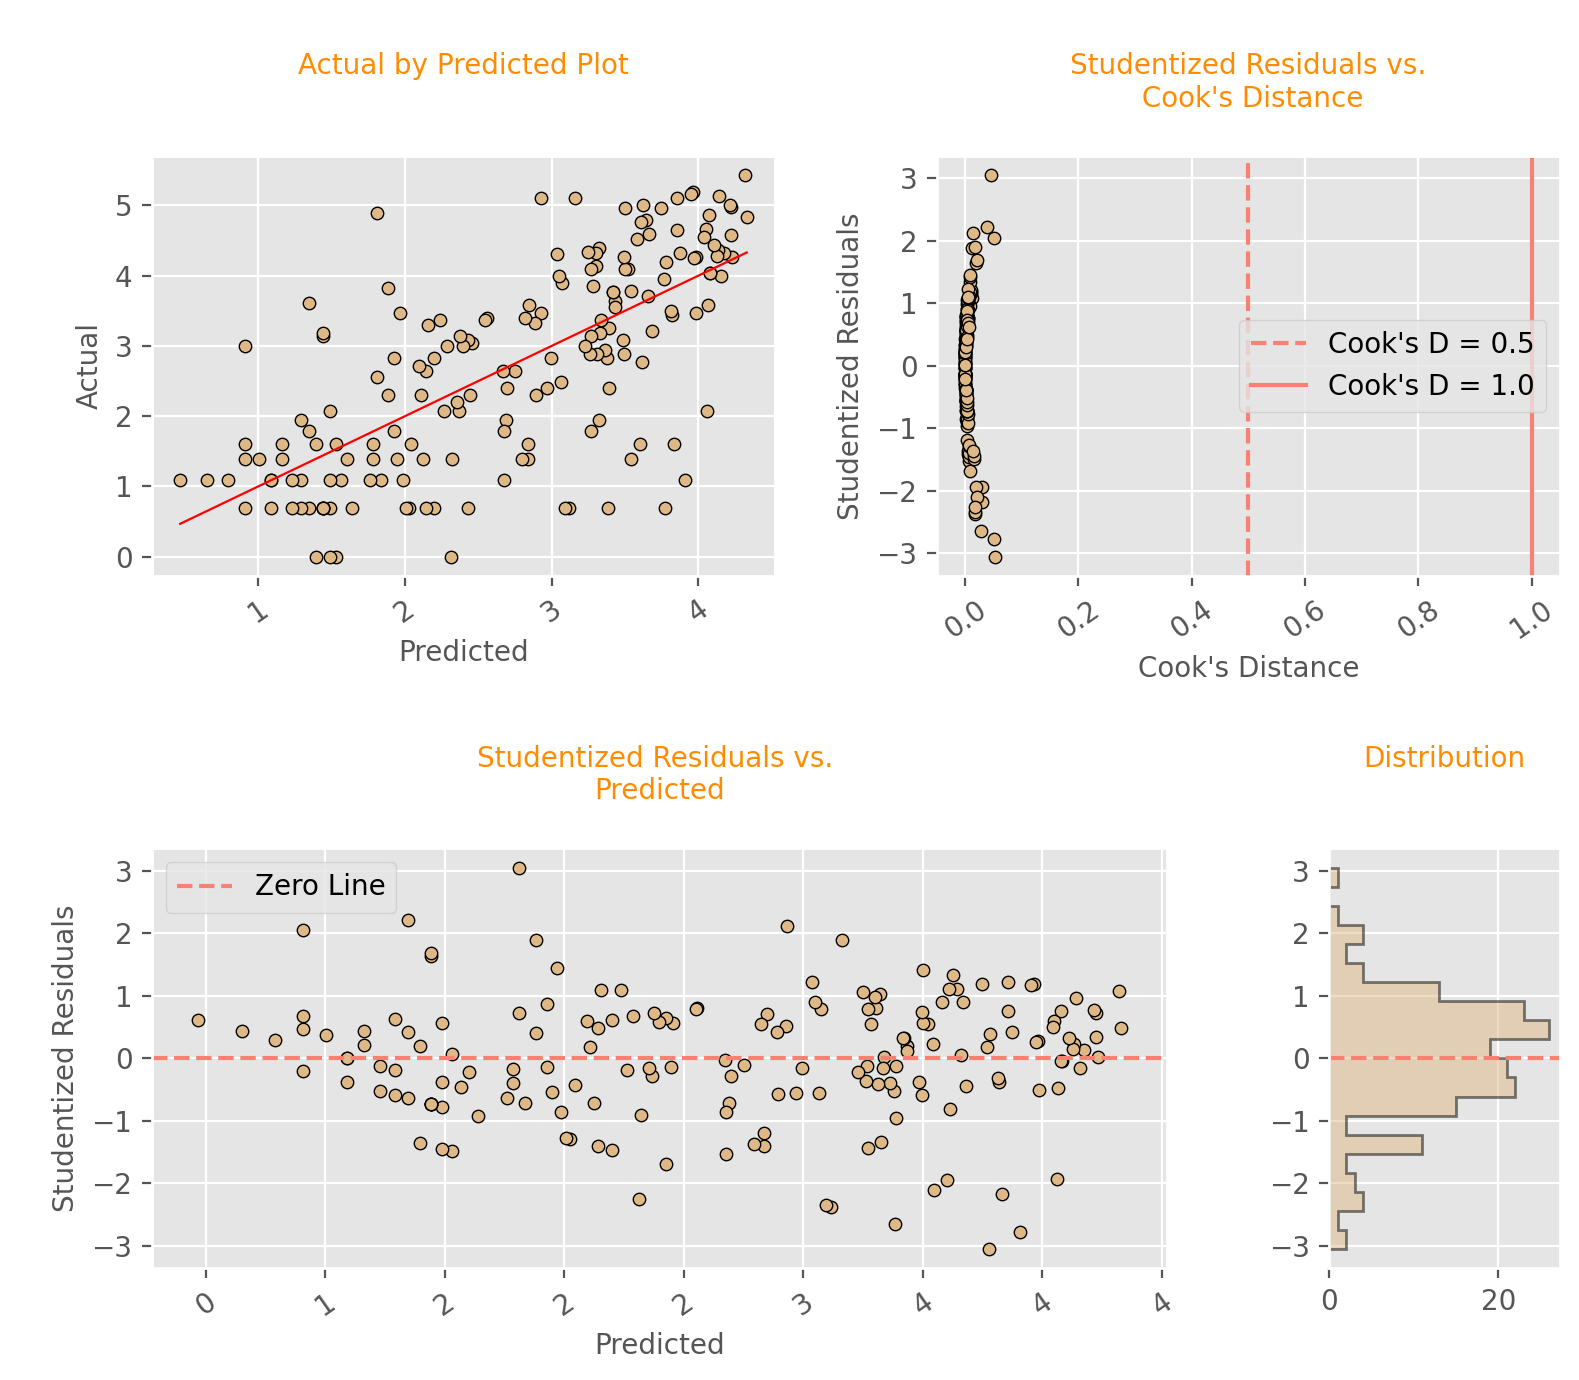

In [103]:
df, fitted_wls_model = all_possible_models(y_log ,X_log, w, stopping_rule = 'bic')


All Possible Models

Total columns/features:          9
Max coefficients to use:         8
Min coefficients to use:         0
Total number of models to fit:   511
Number of combinations:          511
Number of top models to display: 10

VERIFICATION:

Are you sure you want fit 511 model(s) out of 511 possible combinations?

(Yes/No)

Yes


coeffs num_terms      aic  \
18                            [const, Rush Yds_2017]         1    515.1   
17                                 [const, Att_2017]         1  516.529   
9                   [const, Att_2017, Rush FUM_2017]         2  517.503   
2             [const, Rush 1st_2017, Rush 1st%_2017]         2  534.715   
12                            [const, Rush 1st_2017]         1   535.21   
7                         [const, TD_2017, Lng_2017]         2  535.451   
1   [const, 20+_2017, Rush 1st%_2017, Rush FUM_2017]         3   536.47   
13                                 [const, Lng_2017]         1  540.598   
3                   [const, Lng_2017, Rush FUM_2017]         2  540.611   
5                   [const, 20+_2017, Rush FUM_2017]         2  544.192   

       aicc      bic rsquared_adj      rmse  
18   515.17  521.441      0.48906  0.534168  
17  516.599   522.87     0.484895  0.538522  
9   517.643  527.015     0.484928  0.535393  
2   534.854  544.226     0.432013  0.590396  
12  535.279  541.551     0.427216  0.598824  
7   535.591  544.963     0.429632   0.59287  
1   536.704  549.152     0.429505  0.589575  
13  540.667  546.939      0.40941  0.617439  
3    540.75  550.122     0.412664  0.610508  
5   544.332  553.704     0.400589   0.62306


Best Model Fit Based on AIC


Columns Used:

Rush Yds_2017





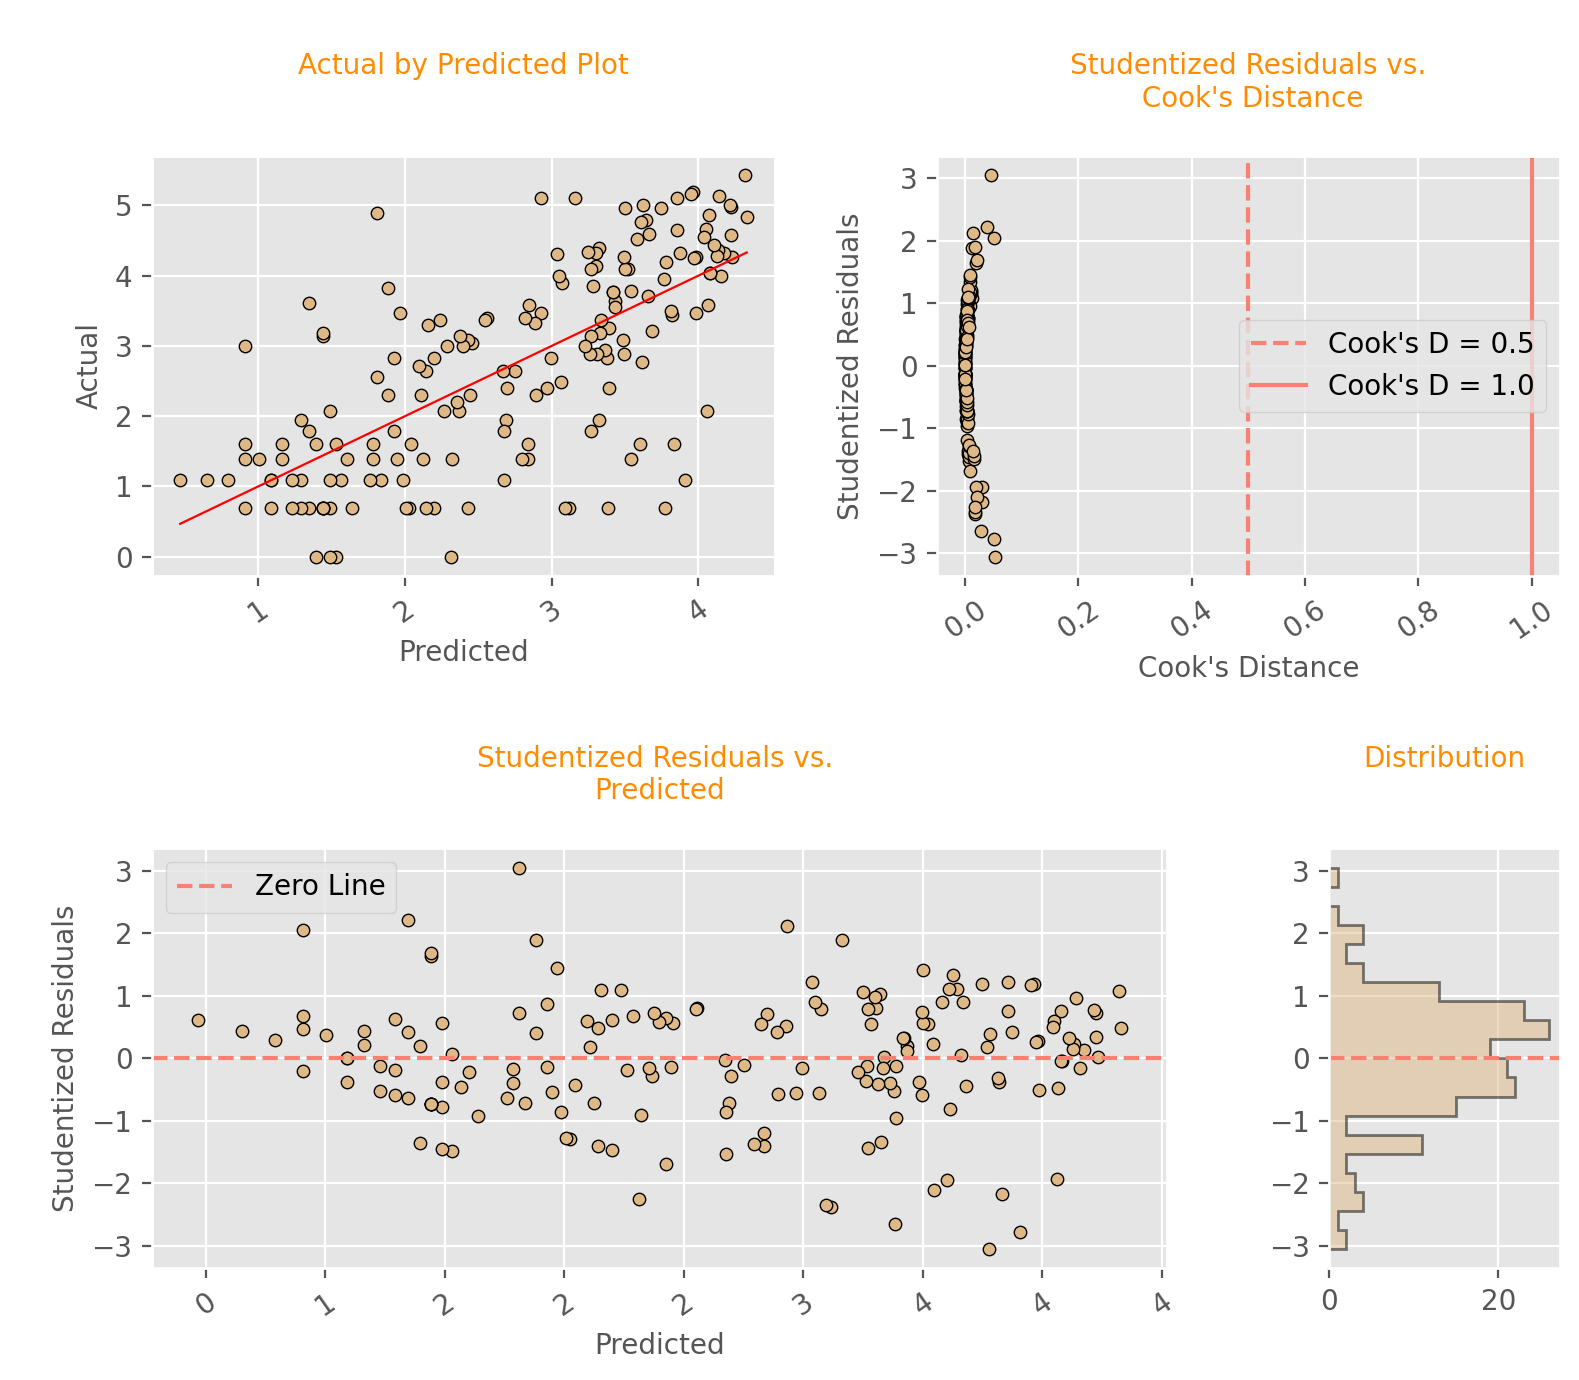

In [105]:
df, fitted_wls_model = all_possible_models(y_log ,X_log, w, stopping_rule = 'aic')


All Possible Models

Total columns/features:          9
Max coefficients to use:         8
Min coefficients to use:         0
Total number of models to fit:   511
Number of combinations:          511
Number of top models to display: 10

VERIFICATION:

Are you sure you want fit 511 model(s) out of 511 possible combinations?

(Yes/No)

Yes


coeffs num_terms      aic  \
52                           [const, Rush Yds_2017]         1  1753.52   
41            [const, Rush Yds_2017, Rush FUM_2017]         2  1754.08   
43                 [const, Rush Yds_2017, Lng_2017]         2  1754.67   
44                 [const, Rush Yds_2017, 40+_2017]         2  1755.02   
42           [const, Rush Yds_2017, Rush 1st%_2017]         2  1755.05   
51                                [const, Att_2017]         1  1759.09   
38                      [const, Att_2017, Lng_2017]         2  1757.65   
47                           [const, Rush 1st_2017]         1  1760.96   
23  [const, Rush Yds_2017, Lng_2017, Rush FUM_2017]         3  1755.21   
24  [const, Rush Yds_2017, 40+_2017, Rush FUM_2017]         3  1755.35   

       aicc      bic rsquared_adj     rmse  
52  1753.59  1759.86     0.437123  607.557  
41  1754.22  1763.59      0.43849  602.598  
43  1754.81  1764.18     0.436616  604.609  
44  1755.15  1764.53     0.435499  605.807  
42  1755.19  1764.56     0.435393  605.922  
51  1759.16  1765.43     0.419027  627.089  
38  1757.79  1767.17     0.426969  614.962  
47  1761.03   1767.3     0.412831  633.777  
23  1755.45  1767.89     0.438002  599.636  
24  1755.58  1768.03     0.437565  600.102


Best Model Fit Based on BIC


Columns Used:

Rush Yds_2017





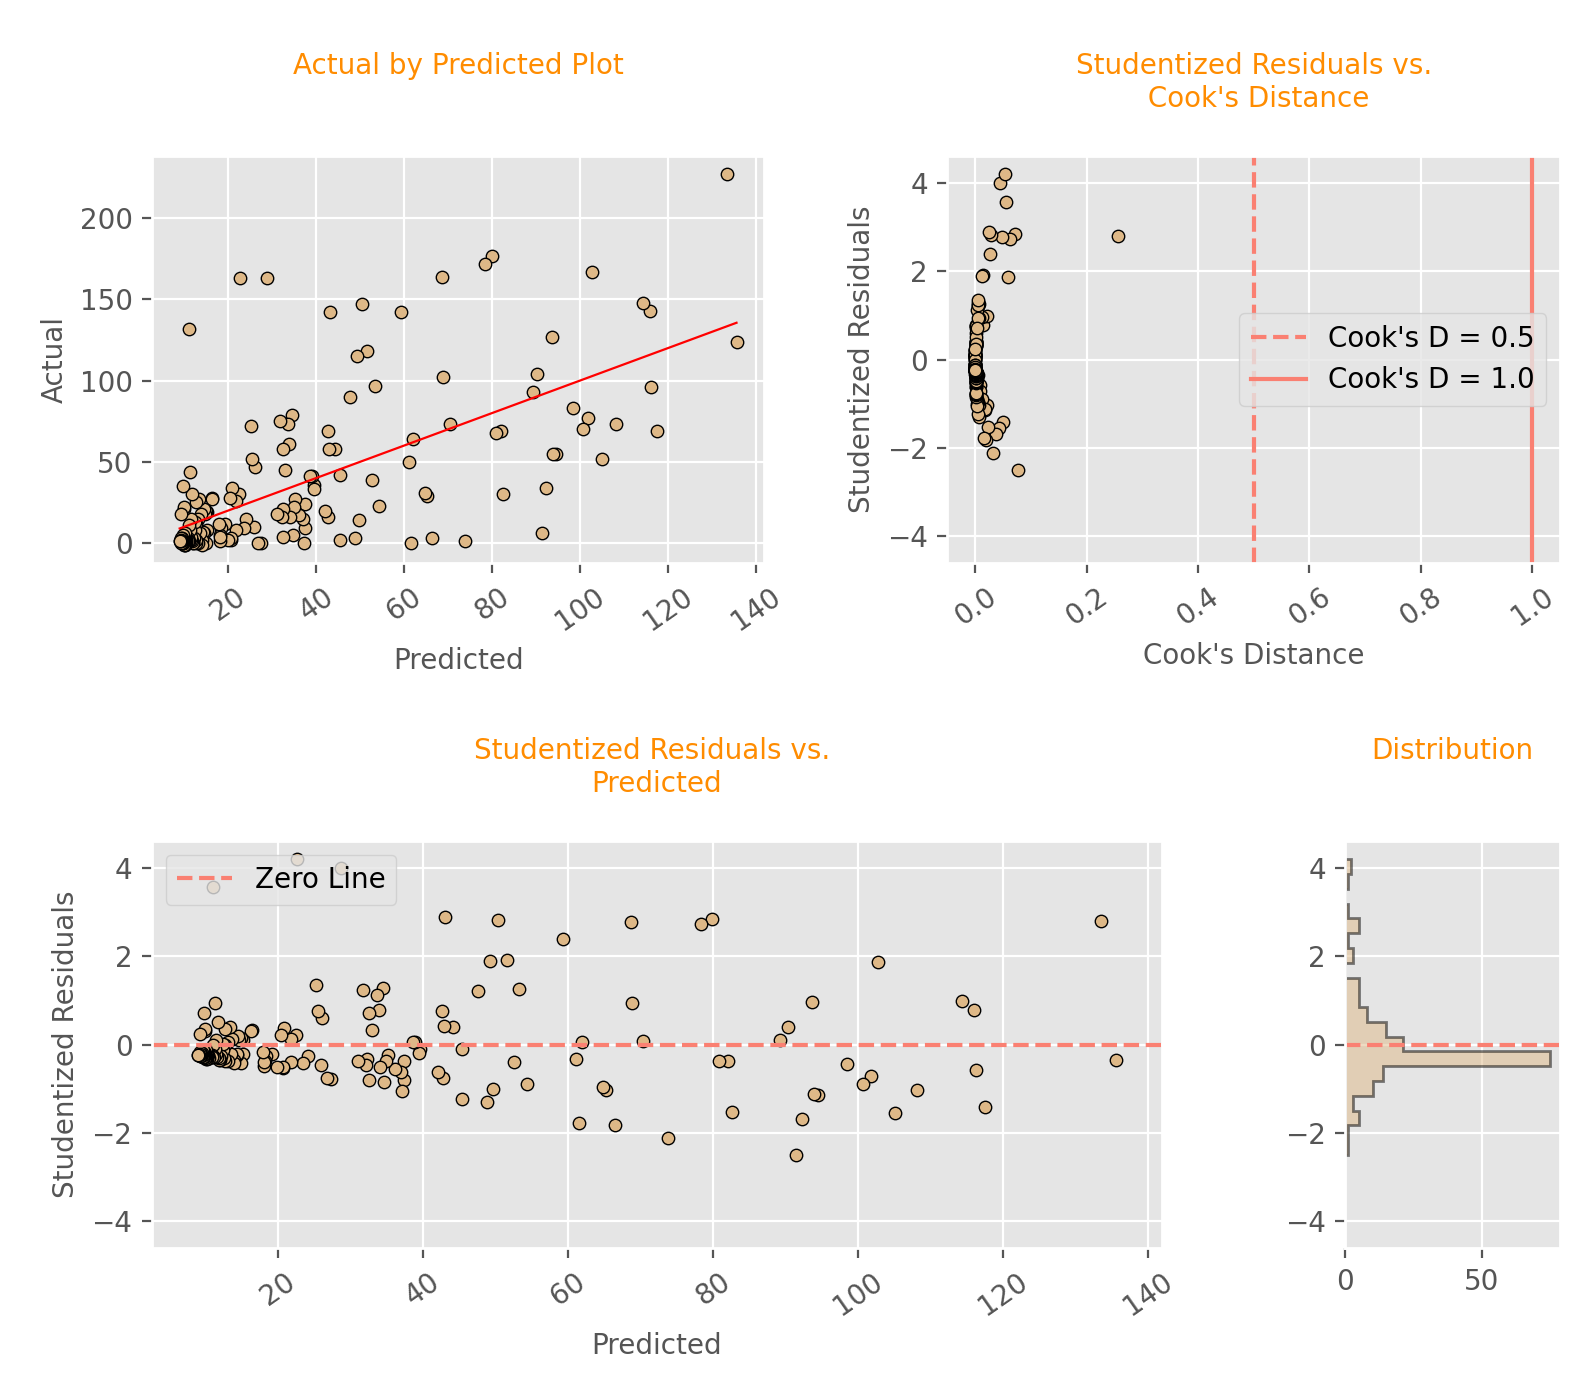

In [81]:
df, fitted_wls_model = all_possible_models(y, X, w, stopping_rule = 'bic')


All Possible Models

Total columns/features:          9
Max coefficients to use:         8
Min coefficients to use:         0
Total number of models to fit:   511
Number of combinations:          511
Number of top models to display: 10

VERIFICATION:

Are you sure you want fit 511 model(s) out of 511 possible combinations?

(Yes/No)

Yes


coeffs num_terms  \
52                                           [const, Rush Yds_2017]         1   
41                            [const, Rush Yds_2017, Rush FUM_2017]         2   
43                                 [const, Rush Yds_2017, Lng_2017]         2   
44                                 [const, Rush Yds_2017, 40+_2017]         2   
42                           [const, Rush Yds_2017, Rush 1st%_2017]         2   
23                  [const, Rush Yds_2017, Lng_2017, Rush FUM_2017]         3   
24                  [const, Rush Yds_2017, 40+_2017, Rush FUM_2017]         3   
22            [const, Rush Yds_2017, Rush 1st%_2017, Rush FUM_2017]         3   
7   [const, Rush Yds_2017, 40+_2017, Rush 1st%_2017, Rush FUM_2017]         4   
8    [const, Rush Yds_2017, TD_2017, Rush 1st%_2017, Rush FUM_2017]         4   

        aic     aicc      bic rsquared_adj     rmse  
52  1753.52  1753.59  1759.86     0.437123  607.557  
41  1754.08  1754.22  1763.59      0.43849  602.598  
43  1754.67  1754.81  1764.18     0.436616  604.609  
44  1755.02  1755.15  1764.53     0.435499  605.807  
42  1755.05  1755.19  1764.56     0.435393  605.922  
23  1755.21  1755.45  1767.89     0.438002  599.636  
24  1755.35  1755.58  1768.03     0.437565  600.102  
22  1755.54  1755.77  1768.22     0.436966  600.741  
7   1756.84  1757.19  1772.69     0.435915  598.363  
8   1757.05   1757.4   1772.9     0.435243  599.076


Best Model Fit Based on AIC


Columns Used:

Rush Yds_2017





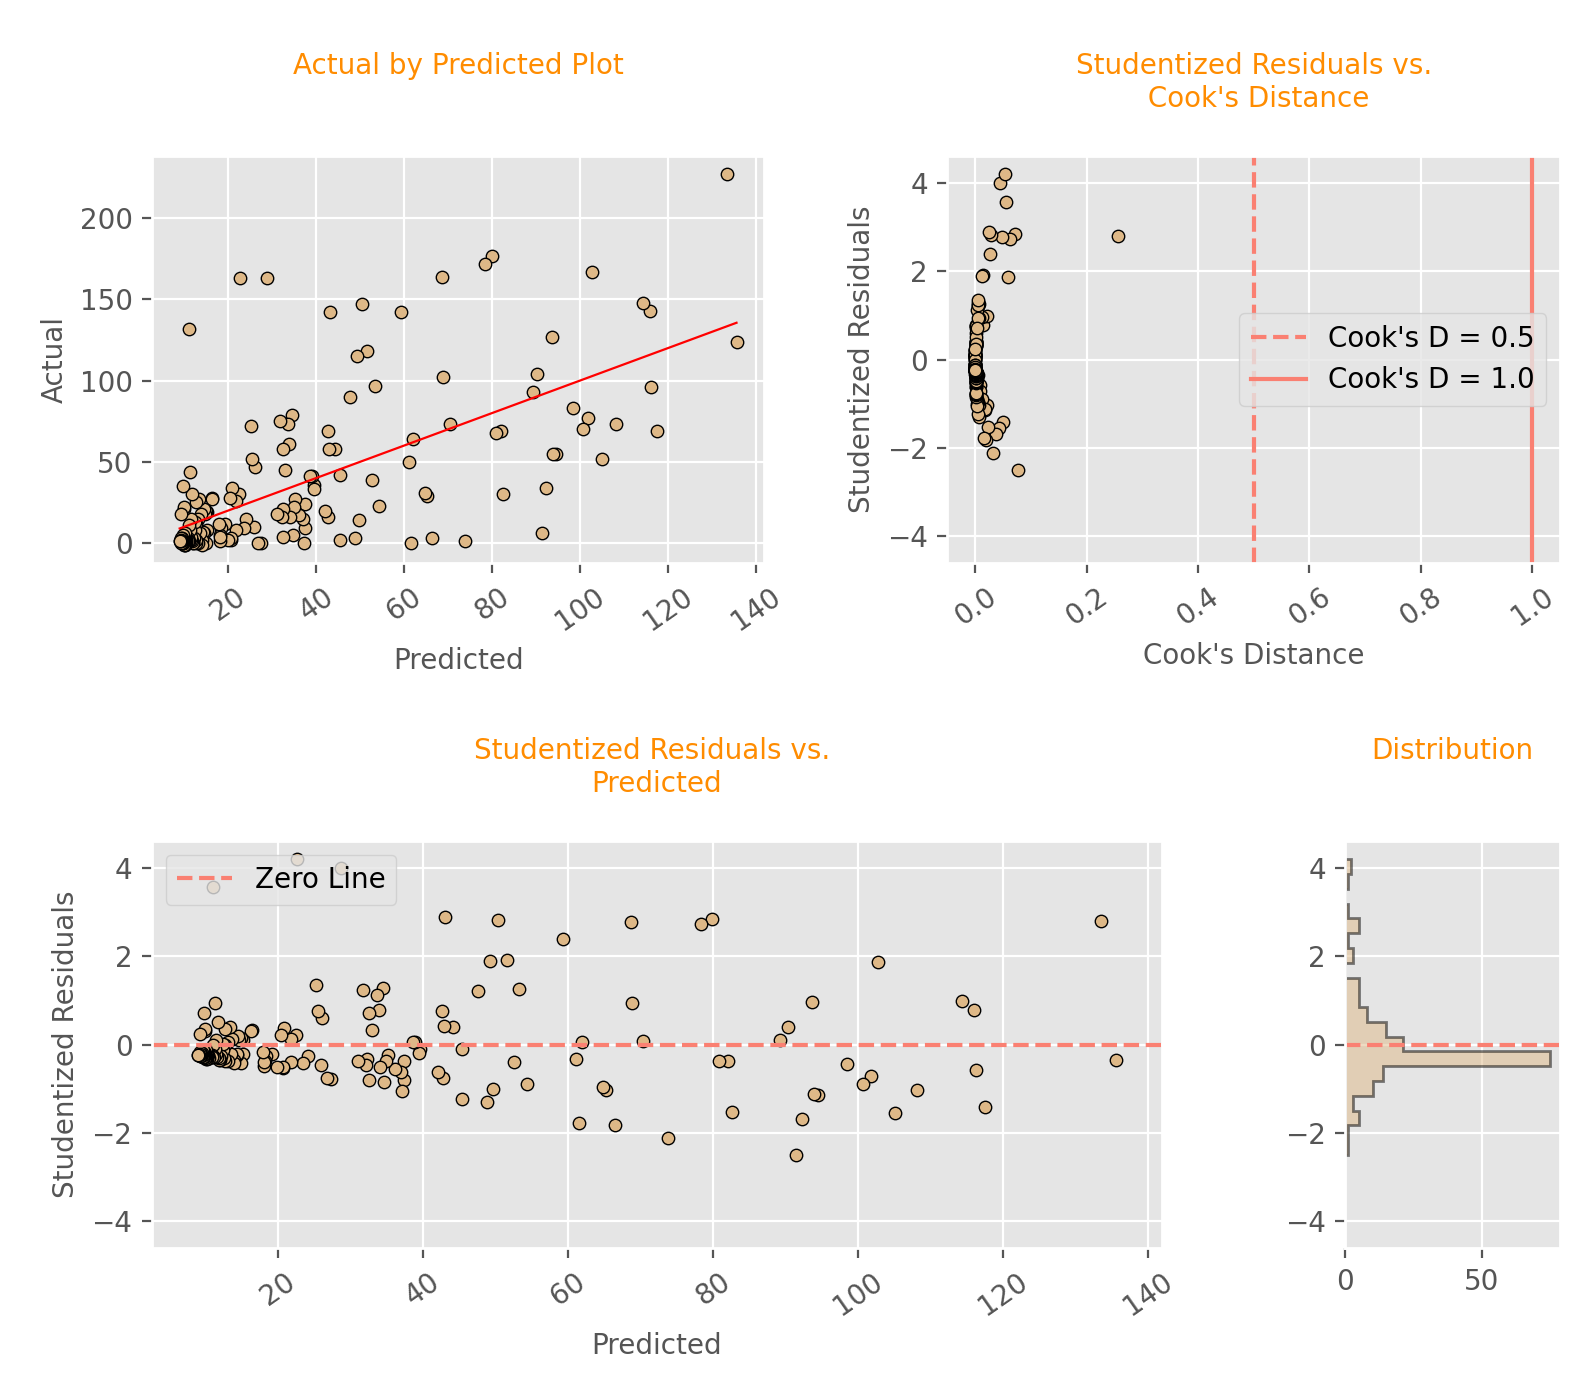

In [82]:
df, fitted_wls_model = all_possible_models(y, X, w, stopping_rule = 'aic')

In [ ]:
nfl_player_stats_rushing_2018['weight'] = 1
nfl_player_stats_rushing_2018 = nfl_player_stats_rushing_2018['weight']
X_train = X_train.drop(columns = ['weight'])

In [ ]:
# create target data points
df_train['points'] = (df_train['Rush Yds_2018']/10).astype(int)+df_train['TD_2018']*6-2*df_train['Rush FUM_2018']
df_test['points'] = (df_test['Rush Yds_2019']/10).astype(int)+df_test['TD_2019']*6-2*df_test['Rush FUM_2019']

In [49]:





# get data
df_train = nfl_player_stats_rushing_2018.copy() 
df_test = nfl_player_stats_rushing_2019.copy() 

# create target data points
df_train['points'] = (df_train['Rush Yds_2018']/10).astype(int)+df_train['TD_2018']*6-2*df_train['Rush FUM_2018']
df_test['points'] = (df_test['Rush Yds_2019']/10).astype(int)+df_test['TD_2019']*6-2*df_test['Rush FUM_2019']

X_train = df_train[['Rush Yds_2018',
                    'Att_2018',
                    'TD_2018',
                    '20+_2018',
                    '40+_2018',
                    'Lng_2018',
                    'Rush 1st_2018',
                    'Rush 1st%_2018',
                    'Rush FUM_2018']]

y_train = df_train['points']

X_test = df_test[['Rush Yds_2019',
                  'Att_2019',
                  'TD_2019',
                  '20+_2019',
                  '40+_2019',
                  'Lng_2019',
                  'Rush 1st_2019',
                  'Rush 1st%_2019',
                  'Rush FUM_2019']]

y_test = df_test['points']


Yay! It's there!
Length of the dataset is  2877
Yay! It's there!
Length of the dataset is  295
Yay! It's there!
Length of the dataset is  304


# Assign Weight

In [50]:
X_train['weight'] = 1
w_train = X_train['weight']
X_train = X_train.drop(columns = ['weight'])

X_test['weight'] = 1
w_test = X_test['weight']
X_test = X_test.drop(columns = ['weight'])


All Possible Models

Total columns/features:          9
Max coefficients to use:         8
Min coefficients to use:         0
Total number of models to fit:   511
Number of combinations:          511
Number of top models to display: 10

VERIFICATION:

Are you sure you want fit 511 model(s) out of 511 possible combinations?

(Yes/No)

Yes


coeffs num_terms  \
110                  [const, Rush Yds_2018, TD_2018, Rush FUM_2018]         3   
63         [const, Rush Yds_2018, TD_2018, 40+_2018, Rush FUM_2018]         4   
61   [const, Rush Yds_2018, TD_2018, Rush 1st%_2018, Rush FUM_2018]         4   
112                       [const, Rush Yds_2018, TD_2018, 40+_2018]         3   
66              [const, Rush Yds_2018, TD_2018, 20+_2018, 40+_2018]         4   
65              [const, Rush Yds_2018, TD_2018, 40+_2018, Lng_2018]         4   
64        [const, Rush Yds_2018, TD_2018, 40+_2018, Rush 1st%_2018]         4   
139                                 [const, Rush Yds_2018, TD_2018]         2   
111                 [const, Rush Yds_2018, TD_2018, Rush 1st%_2018]         3   
62        [const, Rush Yds_2018, TD_2018, Lng_2018, Rush 1st%_2018]         4   

         aic     aicc      bic rsquared_adj       rmse  
110   105.79  105.928  120.538     0.999955  0.0407813  
63   106.127  106.334  124.561     0.999955  0.0405519  
61   107.155  107.363   125.59     0.999955  0.0406936  
112  1269.45  1269.59   1284.2     0.997677     2.1066  
66   1268.84  1269.05  1287.27      0.99769    2.08805  
65   1269.08  1269.29  1287.52     0.997688    2.08977  
64   1270.93  1271.13  1289.36     0.997673    2.10286  
139  1285.96  1286.05  1297.02     0.997535    2.24304  
111  1286.59  1286.73  1301.34     0.997538    2.23261  
62    1288.1   1288.3  1306.53     0.997534    2.22888


Best Model Fit Based on BIC


Columns Used:

Rush Yds_2018
TD_2018
Rush FUM_2018





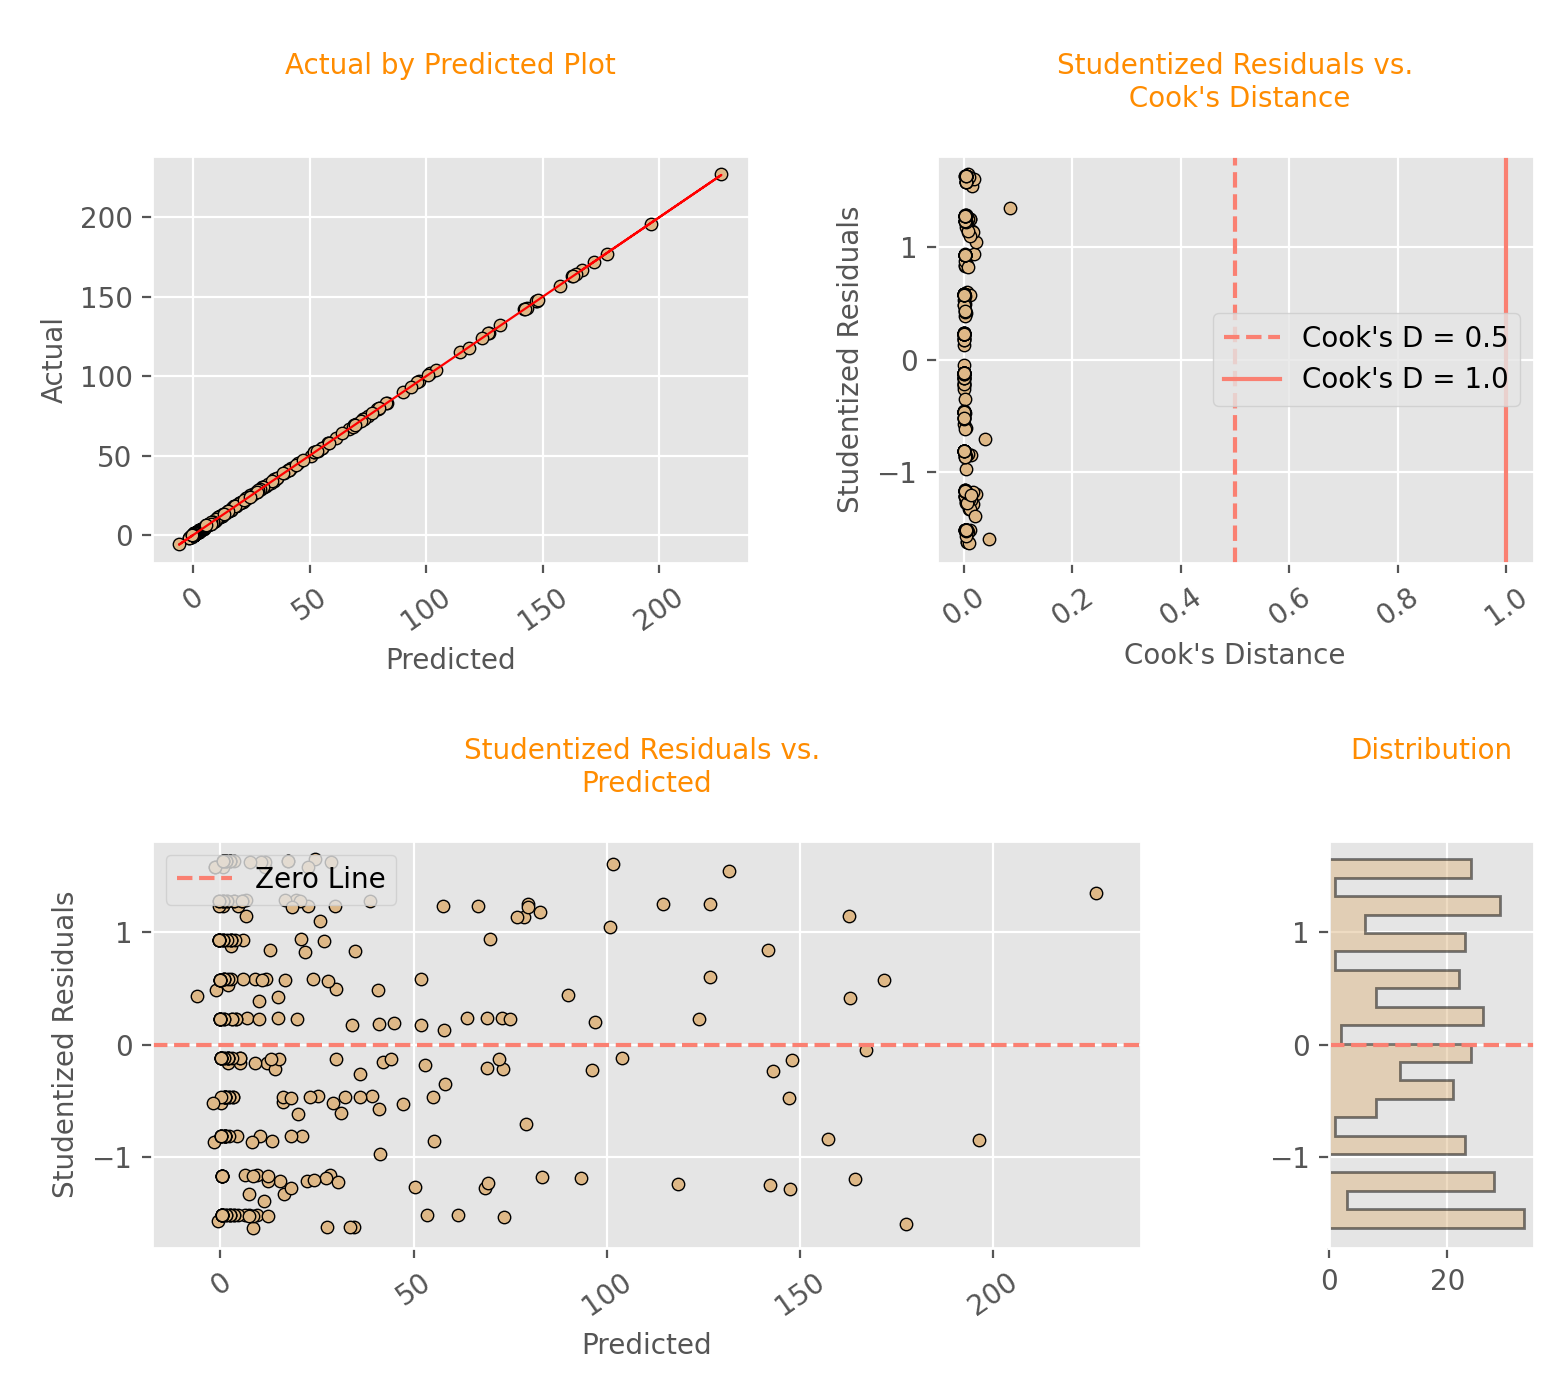

In [51]:
df, fitted_wls_model = all_possible_models(y_train, X_train, w_train)

In [ ]:
fitted_wls_model.predict(exog = (exog, weights))

# Basketball Players

In [ ]:
player_stats_url = 'https://www.basketball-reference.com/leagues/NBA_2013_per_game.html'
stats = pd.read_html(player_stats_url)[0]
stats = stats.fillna(0)
stats = stats.loc[stats['Rk']!= 'Rk']
stats['Player'] = stats['Player'].apply(lambda x: x.replace('*',''))
stats

## Rookies

In [ ]:
rookie_url = 'https://www.basketball-reference.com/leagues/NBA_2013_rookies.html'
rookies = pd.read_html(rookie_url)[0]
rookies = rookies.iloc[:,1].dropna().to_list()
rookies = pd.DataFrame({'Player':rookies})
rookies['Rookie'] = 1
rookies.head()

## Basketball Player Salaries

In [ ]:
salaries = pd.DataFrame()
for page_number in range(1,13):
    player_salaries_url = 'http://www.espn.com/nba/salaries/_/year/2013/page/{}/seasontype/1'.format(page_number)
    print(player_salaries_url)
    read_salaries = pd.read_html(player_salaries_url)[0]
    frames = [salaries, read_salaries]
    salaries = pd.concat(frames)
salaries.head(20)

### Merge the Datasets

In [ ]:
data = salaries.merge(rookies, how = 'left', left_on = 1, right_on = 'Player')
data = data.fillna(0).drop(columns = ['Player'])
data

In [ ]:
stats

In [ ]:
testing = data.merge(stats, how = 'left', left_on = 1, right_on = 'Player')
testing.tail()

In [ ]:
data = data.merge(stats, how = 'left', left_on = 1, right_on = 'Player').dropna()
data = data.drop(columns = [1, 'Rk'])
data = data.rename(columns = {3:'Salary'})
data.head(20)

### Get Dummies

In [ ]:
df = data.copy()
df = df.drop(columns = ['Pos','Tm'])
for col in df.columns:
    if col != 'Player':
        df[col] = pd.to_numeric(df[col])
        
df = df.groupby('Player').mean()
df

### Assign X and y variables

In [ ]:
y = df['Salary']
X = df[[col for col in df.columns if col != 'Salary']]
X

In [ ]:
params = np.array(fitted_wls_model.params)

In [ ]:
exog = np.array(X_test)
exog

In [ ]:
weights = np.array(w_test)
weights


In [ ]:
fitted_wls_model.predict(exog = (exog, weights))

In [ ]:
fitted_wls_model.exog_names()

In [ ]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

yhat_2019 = fitted_wls_model.predict(X_test)
#.predict(exog=dict(x1=x1n))

In [ ]:
X_test.info()

In [ ]:
X_train.info()

In [ ]:
if len([feature for feature in df.iloc[0][0] if feature != 'const']) <= 1:
    print('You need more than one column/feature to compute a marginal model plot.'')

In [ ]:
columns = [feature for feature in df.iloc[0][0] if feature != 'const']
columns

In [ ]:
def marginal_model_plots(y, yhat, X, smoothness = 0.5):
    
    def find_number_features(X):
    
        try:
            return X.shape[1]
        except:
            return 1
    
    def find_number_rows(num_features):
    
        num_rows = int(num_features/4)
        if num_features%4 > 0:num_rows += 1 
        return num_rows

    def find_number_columns(num_features):

        if num_features<4:
            return num_features

        else:
            return 4
    
    num_features = find_number_features(X)
    num_rows = find_number_rows(num_features)
    num_columns = find_number_columns(num_features)

    fig, ax = plt.subplots(num_rows, num_columns, sharex=False, figsize=(num_columns*10,num_rows*10), dpi = 200)
    fig.suptitle('Marginal Model Plots\n', color = 'orange', fontsize=25)
    
    row = 0
    col = 0
    coeff_num = 1
    y_smooth = smooth_lowess(y)
    yhat_smooth = smooth_lowess(yhat)

    # start off by turning off all the axis

#     for c in range(0,num_columns):
#         for r in range(0,num_rows):
#             ax[r,c].axis('off')

    for column_name in X.columns:

        # turn the axis back on for those boxes that have plots
        #ax[row,col].axis('on')
        
        values = X[column_name]
        smoothed_values = smooth_lowess(values)
        x_max = X[column_name].max()
        x_min = X[column_name].min()
        y_max = y.max()
        y_min = y.min()      
        
        data = pd.DataFrame({'x':values,'y':y,'yhat':yhat}).sort_values('x').reset_index(drop = True)
        data['y_smooth'] =  smooth_lowess(data['y'], lowess_window_length = 100, smoothing_iterations = 5)
        data['yhat_smooth'] =  smooth_lowess(data['yhat'], lowess_window_length = 100, smoothing_iterations = 5)
        data['x_smooth'] = smooth_lowess(data['x'], lowess_window_length = 100, smoothing_iterations = 5)
        
        values = data['x']
        smoothed_values = data['x_smooth']
        x_max = X[column_name].max()
        x_min = X[column_name].min()
        y_max = y.max()
        y_min = y.min()        

#         if num_rows == 1:
#             print('THIS SHIT:' num_columns, num_rows)
            
#             if num_columns == 1:
#                 fig, ax = plt.subplots(figsize=(num_columns*10,num_rows*10, squeeze=False), dpi = 200)
    
#             ax[col].set_title(column_name, fontsize = 40)
#             ax[col].scatter(data['x'], data['y'], s = 1, color = 'black', alpha = 0.9)
#             ax[col].scatter(data['x'], data['yhat'], s = 1, color = 'blue', alpha = 0.9)

#             ax[col].plot(data['x_smooth'], data['y_smooth'], color = 'black', linestyle = '-', linewidth = 5.5, alpha = 0.55, label = 'Actual')
#             ax[col].plot(data['x_smooth'], data['yhat_smooth'], color = 'blue', linestyle = '--', linewidth = 5.5, alpha = 0.95, label = 'Predicted')    

#             ax[col].set_ylabel('y',  rotation=0, fontsize = 20, labelpad=20)
#             ax[col].set_xlabel('Coeff {}'.format(coeff_num), fontsize = 20, labelpad=20)

#             ax[col].set_xlim(x_min,x_max)
#             ax[col].set_ylim(y_min,y_max)
#             ax[col].legend(fontsize = 24, loc = 1)
              
#        else: 
        if num_rows == 1 and num_columns == 1: 
            
            ax = np.array([[ax]])
            
            
        ax[row,col].set_title(column_name, fontsize = 40)
        ax[row,col].scatter(data['x'], data['y'], s = 1, color = 'black', alpha = 0.9)
        ax[row,col].scatter(data['x'], data['yhat'], s = 1, color = 'blue', alpha = 0.9)

        ax[row,col].plot(data['x_smooth'], data['y_smooth'], color = 'black', linestyle = '-', linewidth = 5.5, alpha = 0.55, label = 'Actual')
        ax[row,col].plot(data['x_smooth'], data['yhat_smooth'], color = 'blue', linestyle = '--', linewidth = 5.5, alpha = 0.95, label = 'Predicted')    

        ax[row,col].set_ylabel('y',  rotation=0, fontsize = 20, labelpad=20)
        ax[row,col].set_xlabel('Coeff {}'.format(coeff_num), fontsize = 20, labelpad=20)

        ax[row,col].set_xlim(x_min,x_max)
        ax[row,col].set_ylim(y_min,y_max)
        ax[row,col].legend(fontsize = 24, loc = 1)

        coeff_num +=1
        col+=1
        if col>=4:
            col=0
            row+=1
    

In [ ]:
results, fitted_wls_model = wls_regression(
    y,
    X[['avg_carry_distance']],
    w,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=True,
    display_marginal_model_plots=True,
    return_data=True
)

In [ ]:
%debug

In [ ]:
football_stats = pd.read_pickle('./nfl_player_stats_receiving_2019.pkl')
football_stats['points'] = football_stats['receiving__2019']+round(football_stats['receiving_yds_2019']/10)+football_stats['receiving_td_2019']*6-football_stats['receiving_fum_2019']*2

In [ ]:
X = X.copy()
y = y.copy()
w = w.copy()
max_cols = 8 
min_cols = 0
num_show = 10
pval_max = 0.05
vif_max = 10
add_intercept = True
stopping_rule = 'bic'
screen_pvalues = True
screen_vifs = True

cols_list = X.columns.to_list()
total_cols = len(X.columns.to_list())

from tqdm.notebook import tqdm_notebook as tqdm
import math

if max_cols > total_cols:
    max_cols = total_cols

total_model_fits = find_num_models(total_cols, max_cols, min_cols)
total_iterations = num_combinatons_powerset(total_cols)-1

print('\nAll Possible Models\n')
print('Total columns/features:          {}'.format(total_cols))
print('Max coefficients to use:         {}'.format(max_cols))
print('Min coefficients to use:         {}'.format(min_cols))
print('Total number of models to fit:   {}'.format(total_model_fits)) 
print('Number of combinations:          {}'.format(total_iterations))
print('Number of top models to display: {}'.format(num_show))

go_no_go = input('\nVERIFICATION:\n\nAre you sure you want fit {} model(s) out of {} possible combinations?\n\n(Yes/No)\n\n'.format(total_model_fits, total_iterations))
go_no_go = go_no_go.lower()



pbar = tqdm(total=total_iterations-1) # display progress...

sets = list(powerset(cols_list))

all_models = {}
model_num = 0

for cols in sets[1:][::-1]:
    pbar.update(1)
    
    if len(cols) < min_cols or len(cols) > max_cols:  #screen out columns from max or min
        continue
    
    X_predictors = X[list(cols)]
    
    if add_intercept == True:
        X_predictors = sm.add_constant(X_predictors)
    
    # fitted model
    model_wls = sm.WLS(y, X_predictors, weights=w) # fit model
    fitted_wls = model_wls.fit()
    
    # screen for pvalues and vifs
    
    pvalues = list((fitted_wls.pvalues).values)
    vifs = list(get_vifs(X_predictors, add_intercept).values)
    
    # screen for pvalues
    if screen_pvalues == True and max([0 if np.isnan(val) else val for val in pvalues]) >= pval_max:
                continue

    # screen for vifs
    if screen_vifs == True and max([0 if np.isnan(val) else val for val in vifs]) > vif_max:
                continue

    # metrics
    model_num += 1
    num_terms = len(cols)
    coeffs = list((fitted_wls.pvalues).index)

    llf = fitted_wls.llf
    nobs = fitted_wls.nobs
    df_modelwc = len(pvalues)
    aic = fitted_wls.aic
    aicc = sm.tools.eval_measures.aicc(llf, nobs, df_modelwc)
    bic = fitted_wls.bic
    rsquared_adj = fitted_wls.rsquared_adj
    rmse = (
        (mean_squared_error(y,fitted_wls.predict(sm.add_constant(X_predictors))))*0.5 if add_intercept==True
        else (mean_squared_error(y,fitted_wls.predict(X_predictors)))*0.5
    )
    
    all_models[model_num] = [coeffs, pvalues, vifs, num_terms, aic, aicc, bic, rsquared_adj, rmse]

    # display progress  
    
pbar.close()  
df = pd.DataFrame(all_models).T
df.columns = ['coeffs', 'pvalues', 'vif', 'num_terms', 'aic', 'aicc', 'bic', 'rsquared_adj', 'rmse']
df = df[['coeffs', 'num_terms', 'aic', 'aicc', 'bic', 'rsquared_adj', 'rmse']]
df = df.sort_values(by = stopping_rule)
display(df.head(num_show))


In [ ]:
#[x+1 if x >= 45 else x+5 for x in l]
[0 if np.isnan(val) else val for val in vifs]


In [ ]:
[0 if val else val for val in pvalues if np.isnan(val)]

In [ ]:
[val for val in pvalues]

In [ ]:
np.isnan(np.nan)

In [ ]:
#[a if tC else b for i in items if fC]
max([0 if val else val for val in pvalues if ~np.isnan(val)])

In [ ]:
vif_scores = [np.nan, 52912.60132567192, 54982.409052273164, 429.19001774028266, 4666.177330170132, 72.50041214145082, 935.3435762701599, 11815.390389782413]
#[col for col in vif_scores if col != ]
max([x for x in vif_scores if ~np.isnan(x)])
#vif_scores[~ np.isnan(vif_scores)]

In [ ]:
np.insan(x)

In [ ]:
max([x for x in pvalues if ~np.isnan(x)])

In [ ]:
df

In [ ]:
for pval in pvalues:
    if pval >= pval_max:
        continue
for vif in vifs:
    if vif >= vif_max:
        continue


In [ ]:
vifs

In [ ]:
vifs = get_vifs(X_predictors, add_intercept)
vifs

In [ ]:
coeffs

In [ ]:
df = pd.DataFrame(all_models).T
df

In [ ]:
list((fitted_wls.pvalues).values)


In [ ]:
coeffs

In [ ]:
list(pvalues.index)

In [ ]:
columns_list = ['A','B','C','D','E','F','G','H']

min_col_length = 1

total_combinations = num_combinatons_powerset(len(columns_list))

pbar = tqdm(total=total_combinations-1) # display progress...

from itertools import chain, combinations
# iterable engine made by AJ Hill
def powerset(iterable):
    
    s = list(iterable)
    
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

sets = list(powerset(columns_list))

for col in sets[1:][::-1]:
    pbar.update(1)
    if len(col) < min_col_length or len(col) > max_col_length:
        
        print(list(col))
        continue
                
    # display progress  
pbar.close()   

In [ ]:
2**7

In [ ]:
sets[::-1]

In [ ]:
from itertools import combinations 
  
letters ="GeEKS"
  
# size of combination is set to 3 
a = combinations(letters, 3)  
y = [' '.join(i) for i in a] 
  
print(y)

In [ ]:
#columns_list = X.columns.to_list()
columns_list = ['A','B', 'C']
all_combinations = list(generate_combinations(columns_list , rolls = 3))
all_combinations

In [ ]:
def generate_combinations(outcomes, rolls=1):
    
    # outcome generator developed by AJ Hill
    
    N = len(outcomes)
    if N == 0 or rolls == 0:
        yield []
        return
   
    indices = [0 for _ in range(rolls)]
    for i in range(N**rolls):
        yield [outcomes[index] for index in indices]
       
        for i in range(rolls):
            indices[i] += 1
            if indices[i] == N:
                indices[i] = 0
            else:
                break

In [ ]:
all_combinations = list(generate_combinations(list('UL'), rolls = 2))
all_combinations

In [ ]:
def color_negative_red(val, stopping_rule):
    if stopping_rule = 'minimum_BIC'
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    
    color = 'orange' if val < 0 else 'black'
    return 'color: %s' % color

In [ ]:
s = df.style.applymap(color_negative_red)
s

In [ ]:
s = step_history.style.set_properties(**{'text-align': 'left'})
s = s.set_caption('Step History').set_table_styles(
    [{'selector': 'caption', 'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]}]
)
s

In [ ]:
def beautify_summary_of_fit(summary_of_fit):
    
    summary_of_fit[''] = round(summary_of_fit[''],6)
    summary_of_fit= summary_of_fit.astype(str)
    
    summary_of_fit[''].iloc[-1] = summary_of_fit[''].iloc[-1].replace('.0','')

    s = summary_of_fit.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Summary of Fit').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    
    return s

In [ ]:
results, fitted_wls_model, step_history = wls_model_selection(
    y, 
    X, 
    w, 
    method = 'stepwise_fit_backward', 
    stopping_rule = 'minimum_AIC'
)

In [ ]:
step_history

In [ ]:
def get_columns_from_step_history(step_history, step_num):
    cols = step_history.iloc[step_num-1,-1]
    return cols

In [ ]:
cols = get_columns_from_step_history(step_history, 4)
print(cols)

In [ ]:
y = y
w = w
X_ish = X[cols].copy()

results, fitted_ols_model = wls_regression(
    y,
    X_ish,
    w,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=True,
    display_marginal_model_plots=True,
    return_data=True
)

In [ ]:
football_stats = pd.read_pickle('./nfl_player_stats_receiving_2019.pkl')

In [ ]:
football_stats

In [ ]:
football_stats['weight'] = 1

In [ ]:
w = football_stats['weight']

In [ ]:
football_stats[[col for col in football_stats.columns if col not in ['Player', 'weight', '']]

In [ ]:
y = foot